In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA

from discopy.grammar import Word
from discopy.rigid import Cup, Id, Ty
import torch
import random

from sentence_transformers import SentenceTransformer

from lambeq import LossFunction, PennyLaneModel, PytorchTrainer, QuantumTrainer, SPSAOptimizer, NumpyModel, MSELoss, Dataset, AtomicType, IQPAnsatz, BobcatParser, Sim14Ansatz, Sim15Ansatz, StronglyEntanglingAnsatz
from lambeq.pregroups import remove_cups

import jax.numpy as jnp
import jax
jax.devices()

[CpuDevice(id=0)]

# Sadrzadeh-Kartsaklis-Transitive WordData Import

In [2]:
# read the text file into a pandas dataframe
#df = pd.read_csv('Sadrzadeh-Kartsaklis-TransativeWordData.txt', sep=' ')
df = pd.read_csv('Data/LargerSadrKartTransative.txt', sep=' ')

# assign column names to the dataframe
df.columns = ['annotator', 'subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2', 'score']

# group the data by the three sentence columns and calculate the mean and standard deviation of the score column
grouped_data = df.groupby(['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']).agg({'score': [np.mean, np.std]}).reset_index()

# flatten the multi-level column names of the grouped data
grouped_data.columns = [' '.join(col).strip() for col in grouped_data.columns.values]

# rename the mean and std columns to 'score' and 'range' respectively
grouped_data.rename(columns={'score mean': 'score', 'score std': 'range'}, inplace=True)
grouped_data['score'] = grouped_data['score']/grouped_data['score'].max()

unique_word_list = []
for ind, row in grouped_data.iterrows():
	for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
		unique_word_list.append(i)
unique_word_list = list(set(unique_word_list)) #Makes word_list from word_list's unique elements

grouped_data.to_csv("Data/AveragedLargerSadrKartTransative.txt")
grouped_data.describe()

,score,range
count,108.000000,108.000000
mean,0.372650,0.923883
std,0.230505,0.538162
min,0.162338,0.000000
25%,0.187923,0.495386
50%,0.269481,0.972611
75%,0.514069,1.348797
max,1.000000,1.929594


In [3]:
grouped_data

,subject1,verb1,object1,subject2,verb2,object2,score,range
0,agent,sell,property,family,buy,home,0.507305,1.541104
1,agent,sell,property,group,hold,meeting,0.189394,0.481543
2,author,write,book,delegate,buy,land,0.183512,0.625543
3,author,write,book,man,hear,word,0.266234,1.036018
4,author,write,book,writer,read,word,0.514069,1.090140
...,...,...,...,...,...,...,...,...
103,woman,drink,water,doctor,use,test,0.182630,0.448427
104,woman,drink,water,system,use,method,0.175866,0.408248
105,worker,join,party,employee,leave,company,0.227273,0.577350
106,writer,read,word,family,receive,letter,0.339433,1.341963


In [4]:
len(grouped_data['subject1'].unique()), len(grouped_data['verb1'].unique()), len(grouped_data['object1'].unique()), len(grouped_data['subject2'].unique()), len(grouped_data['verb2'].unique()), len(grouped_data['object2'].unique())

(55, 59, 61, 51, 56, 60)

# Sentance Embeddings

In [5]:
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

SENT_similarities_subject = []

for ind, row in grouped_data.iterrows():
	rows_embeddings = []
	sent1 = row['subject1']+" "+row['verb1']+" "+row['object1']
	sent1_embeddings = embedder.encode(sent1)
	#sent1_embeddings = sent1_embeddings /  sent1_embeddings.max()
	sent2 = row['subject2']+" "+row['verb2']+" "+row['object2']
	sent2_embeddings = embedder.encode(sent2)
	#sent2_embeddings = sent2_embeddings /  sent2_embeddings.max()
	SENT_similarities_subject.append(1-cosine(sent1_embeddings, sent2_embeddings))

grouped_data['SENT_sent_sim'] = SENT_similarities_subject
grouped_data.corr(numeric_only = True, method='spearman')

,score,range,SENT_sent_sim
score,1.000000,0.858698,0.797066
range,0.858698,1.000000,0.598361
SENT_sent_sim,0.797066,0.598361,1.000000


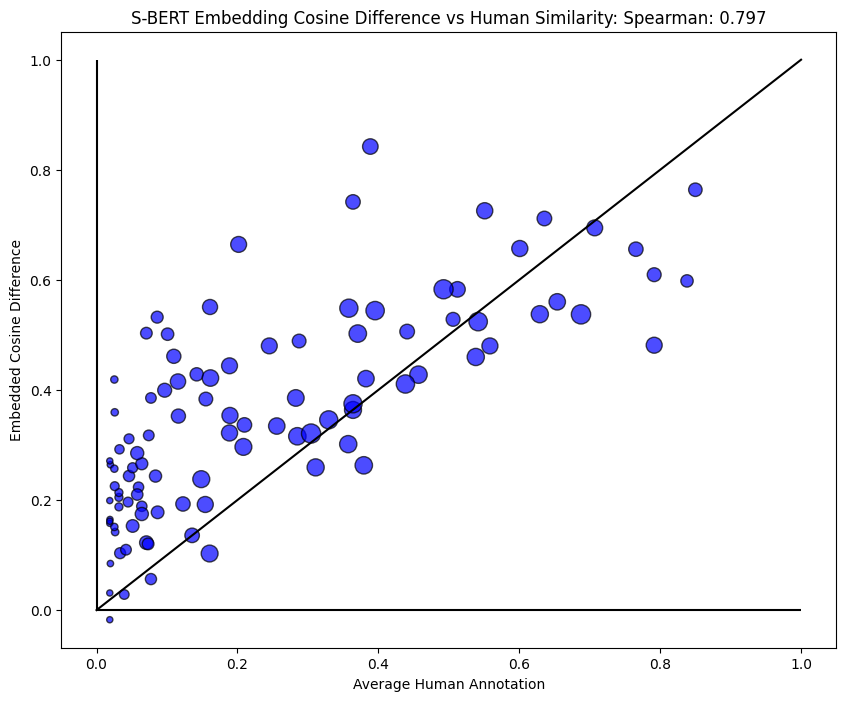

In [6]:
x_values = grouped_data['score']  # Average human annotation
y_values = grouped_data['SENT_sent_sim']  # Embedded cosine difference
bubble_sizes = 100*grouped_data['range']  # Range of human annotation

plt.figure(figsize=(10, 8))
plt.scatter(x_values-0.15, y_values+0.1, s=bubble_sizes, alpha=0.7, c='blue', edgecolors='black')
#plt.errorbar(x_values-0.15, y_values+0.1, yerr=bubble_sizes/600, fmt='o', markersize=0, ecolor='red', capsize=2, label='Range', alpha=0.2)
plt.plot([0,1],[0,1], color='k')
plt.hlines(0, 0,1, colors='k')
plt.vlines(0, 0,1, colors='k')
plt.xlabel('Average Human Annotation')
plt.ylabel('Embedded Cosine Difference')
plt.title("S-BERT Embedding Cosine Difference vs Human Similarity: Spearman: "+str(round(grouped_data['score'].corr(grouped_data['SENT_sent_sim'], method='spearman'), 3)))
plt.grid(False)
plt.show()

# Word Embeddings with Sentence Embedder

In [7]:
BERT_similarities_subject,BERT_similarities_verb,BERT_similarities_obj   = [],[],[]

for ind, row in grouped_data.iterrows():
	rows_embeddings = []
	for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
		rows_embeddings.append(embedder.encode(i))
	sent1 = row['subject1']+" "+row['verb1']+" "+row['object1']
	sent1_embeddings = embedder.encode(sent1)
	BERT_similarities_subject.append(1-cosine(rows_embeddings[0] ,rows_embeddings[3]))
	BERT_similarities_verb.append(1-cosine(rows_embeddings[1] , rows_embeddings[4]))
	BERT_similarities_obj.append(1-cosine(rows_embeddings[2] , rows_embeddings[5]))

grouped_data['SENT_sub_sim'] = BERT_similarities_subject
grouped_data['SENT_verb_sim'] = BERT_similarities_verb
grouped_data['SENT_obj_sim'] = BERT_similarities_obj
grouped_data['ave'] = (grouped_data['SENT_obj_sim'] +grouped_data['SENT_verb_sim'] +grouped_data['SENT_sub_sim'])/3
grouped_data.corr(numeric_only = True, method='spearman')

,score,range,SENT_sent_sim,SENT_sub_sim,SENT_verb_sim,SENT_obj_sim,ave
score,1.000000,0.858698,0.797066,0.630270,0.458983,0.558049,0.746846
range,0.858698,1.000000,0.598361,0.403131,0.446381,0.495584,0.580353
SENT_sent_sim,0.797066,0.598361,1.000000,0.786958,0.420281,0.632657,0.864033
SENT_sub_sim,0.630270,0.403131,0.786958,1.000000,0.245219,0.418000,0.784862
SENT_verb_sim,0.458983,0.446381,0.420281,0.245219,1.000000,0.218815,0.623512
SENT_obj_sim,0.558049,0.495584,0.632657,0.418000,0.218815,1.000000,0.713626
ave,0.746846,0.580353,0.864033,0.784862,0.623512,0.713626,1.000000


(0.1, 1.1)

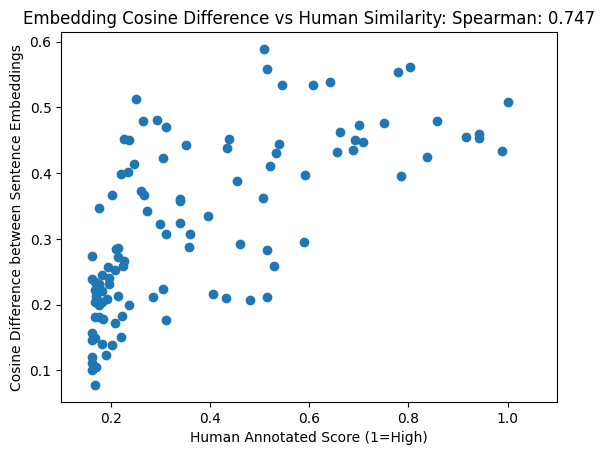

In [8]:
plt.scatter(grouped_data['score'], grouped_data['ave'])
plt.title("Embedding Cosine Difference vs Human Similarity: Spearman: "+str(round(grouped_data['score'].corr(grouped_data['ave'], method='spearman'), 3)))
plt.xlabel("Human Annotated Score (1=High)")
plt.ylabel("Cosine Difference between Sentence Embeddings")
plt.xlim(left=0.1, right=1.1)

Text(0.5, 1.0, 'SquaredError between sum of word encodings and sentence (mean = 0.112)')

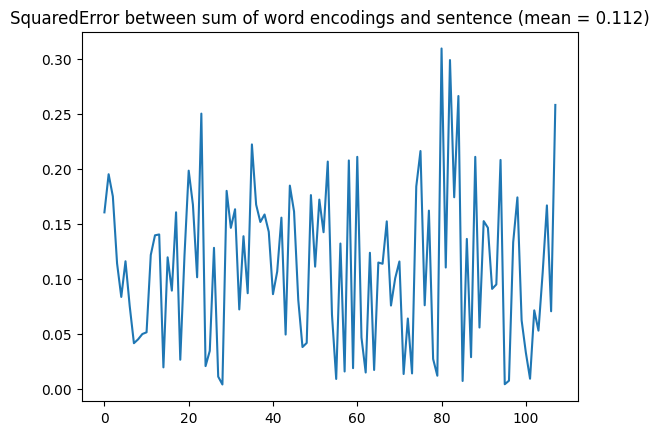

In [9]:
plt.plot(np.sqrt((grouped_data['SENT_sent_sim']- grouped_data['ave'])**2))
plt.title("SquaredError between sum of word encodings and sentence (mean = "+str(np.round(
np.sqrt((grouped_data['SENT_sent_sim']- grouped_data['ave'])**2).mean(), 3))+")")

# Dimension Reduction

In [10]:
def DimReduceByPCA(input_array, new_dims):
	#Pick new_dims Eigenvectors
	pca = PCA(n_components = new_dims)
	pca.fit(input_array)
	data_pca = pca.transform(input_array)
	return data_pca

def DimReduceBySVD(input_array, new_dims):
    U, D, Vt = np.linalg.svd(input_array)
    U_reduced = U[:, :new_dims]
    A_reduced = np.dot(U_reduced, np.diag(D))
    return A_reduced

def RotateWordVector(input_word_vector):
	#Define word as a similarity vector compared to all the other words in corpus
	rotated_word_vector = np.zeroes(len(unique_word_list))
	for index, comaprison_word in enumerate(unique_word_list):
		rotated_word_vector[index] = (1-cosine(input_word_vector, embedder.encode(comaprison_word)))
	return rotated_word_vector

In [11]:
#Making a dict of words as keys do our dimensionality vectors: {word: {dim_method : vector}}
corpus_array = np.zeros(shape=(len(unique_word_list), 384))
word_vector_dict = {}
for i, word in enumerate(unique_word_list):
		vector = embedder.encode(word)
		word_vector_dict.update({word: {len(vector):vector}})
		corpus_array[i] = vector

pca_dim = 10
pca = DimReduceByPCA(corpus_array, pca_dim)
for i, word in enumerate(unique_word_list):
		word_vector_dict[word].update({"pca_"+str(pca_dim):pca[i]})

Text(0, 0.5, 'Change in similarity from 384 dim to 10')

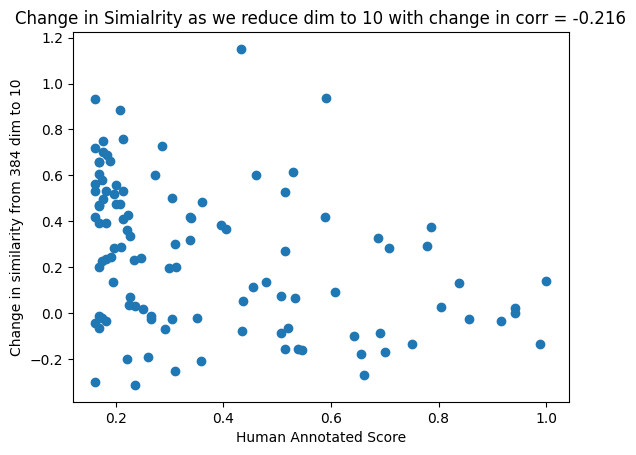

In [12]:
similarities = []
for ind, row in grouped_data.iterrows():
	rows_embeddings = []
	sent1 = word_vector_dict[row['subject1']][384] + word_vector_dict[row['verb1']][384] + word_vector_dict[row['object1']][384]
	sent2 = word_vector_dict[row['subject2']][384] + word_vector_dict[row['verb2']][384] + word_vector_dict[row['object2']][384]

	sent1_low_dim = word_vector_dict[row['subject1']]["pca_"+str(pca_dim)] + word_vector_dict[row['verb1']]["pca_"+str(pca_dim)] + word_vector_dict[row['object1']]["pca_"+str(pca_dim)]
	sent2__low_dim = word_vector_dict[row['subject2']]["pca_"+str(pca_dim)] + word_vector_dict[row['verb2']]["pca_"+str(pca_dim)] + word_vector_dict[row['object2']]["pca_"+str(pca_dim)]
	similarities.append([1-cosine(sent1, sent2), 1-cosine(sent1_low_dim, sent2__low_dim)])

similarities = np.array(similarities)
plt.scatter(grouped_data['score'], similarities[:,0]-similarities[:,1])
plt.title("Change in Simialrity as we reduce dim to "+str(pca_dim) +" with change in corr = "+str(
	np.round(grouped_data['score'].corr(pd.Series(similarities[:,1]), method='spearman') - grouped_data['score'].corr(pd.Series(similarities[:,0]), method='spearman'), 3)
	))
plt.xlabel("Human Annotated Score")
plt.ylabel("Change in similarity from 384 dim to "+str(pca_dim))

In [13]:
grouped_data['PCA_'+str(pca_dim)] = similarities[:,1]
grouped_data.corr(numeric_only = True, method='spearman')

,score,range,SENT_sent_sim,SENT_sub_sim,SENT_verb_sim,SENT_obj_sim,ave,PCA_10
score,1.000000,0.858698,0.797066,0.630270,0.458983,0.558049,0.746846,0.537317
range,0.858698,1.000000,0.598361,0.403131,0.446381,0.495584,0.580353,0.399214
SENT_sent_sim,0.797066,0.598361,1.000000,0.786958,0.420281,0.632657,0.864033,0.721874
SENT_sub_sim,0.630270,0.403131,0.786958,1.000000,0.245219,0.418000,0.784862,0.616374
SENT_verb_sim,0.458983,0.446381,0.420281,0.245219,1.000000,0.218815,0.623512,0.454426
SENT_obj_sim,0.558049,0.495584,0.632657,0.418000,0.218815,1.000000,0.713626,0.527056
ave,0.746846,0.580353,0.864033,0.784862,0.623512,0.713626,1.000000,0.750198
PCA_10,0.537317,0.399214,0.721874,0.616374,0.454426,0.527056,0.750198,1.000000


In [14]:
grouped_data

,subject1,verb1,object1,subject2,verb2,object2,score,range,SENT_sent_sim,SENT_sub_sim,SENT_verb_sim,SENT_obj_sim,ave,PCA_10
0,agent,sell,property,family,buy,home,0.507305,1.541104,0.201549,0.111137,0.687575,0.287326,0.362013,0.394433
1,agent,sell,property,group,hold,meeting,0.189394,0.481543,-0.071638,0.127501,0.288967,-0.046184,0.123428,-0.419797
2,author,write,book,delegate,buy,land,0.183512,0.625543,0.003442,0.157430,0.166433,0.211330,0.178398,-0.365270
3,author,write,book,man,hear,word,0.266234,1.036018,0.252530,0.338995,0.372899,0.388278,0.366724,0.551217
4,author,write,book,writer,read,word,0.514069,1.090140,0.641656,0.755711,0.529858,0.388278,0.557949,0.978626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,woman,drink,water,doctor,use,test,0.182630,0.448427,0.192133,0.172855,0.355742,0.207168,0.245255,0.427217
104,woman,drink,water,system,use,method,0.175866,0.408248,0.125207,0.107123,0.355742,0.230542,0.231135,-0.363076
105,worker,join,party,employee,leave,company,0.227273,0.577350,0.285479,0.751912,0.395919,0.208960,0.452264,0.521499
106,writer,read,word,family,receive,letter,0.339433,1.341963,0.253634,0.239393,0.252427,0.481148,0.324322,0.074801


In [15]:
#Making a dict of words as keys do our dimensionality vectors: {word: {dim_method : vector}}
corpus_array = np.zeros(shape=(len(unique_word_list), 384))
word_vector_dict = {}
for i, word in enumerate(unique_word_list):
        vector = embedder.encode(word)
        word_vector_dict.update({word: {len(vector):vector}})
        corpus_array[i] = vector

for pca_dim in range(1,12):
    pca = DimReduceByPCA(corpus_array, pca_dim)
    for i, word in enumerate(unique_word_list):
            word_vector_dict[word].update({"pca_"+str(pca_dim):pca[i]})
    

In [16]:
word_vector_dict['agent']

{384: array([-0.02489181, -0.35199916, -0.38204622, ..., -0.3539789 ,
        -0.04372901,  0.0109901 ], dtype=float32),
 'pca_1': array([1.40708568]),
 'pca_2': array([ 1.40708568, -1.14017986]),
 'pca_3': array([ 1.40708568, -1.14017986,  0.92208192]),
 'pca_4': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437]),
 'pca_5': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437, -0.56083893]),
 'pca_6': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437, -0.56083893,
         0.07735445]),
 'pca_7': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437, -0.56083893,
         0.07735445, -0.86836529]),
 'pca_8': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437, -0.56083893,
         0.07735445, -0.86836529,  2.41264158]),
 'pca_9': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437, -0.56083893,
         0.07735445, -0.86836529,  2.41264158, -0.17310539]),
 'pca_10': array([ 1.40708568, -1.14017986,  0.92208192,  3.27435437, -0.56083893,
         

# Quantum Encoding

- Choose an Anzatz with invarient Inner Product

- Export circuit from lambeq/discopy to pennylane - possibly not

- tensor network module

- 12 qubits, 

- discopro - removing cups (kinianlo/discopro)

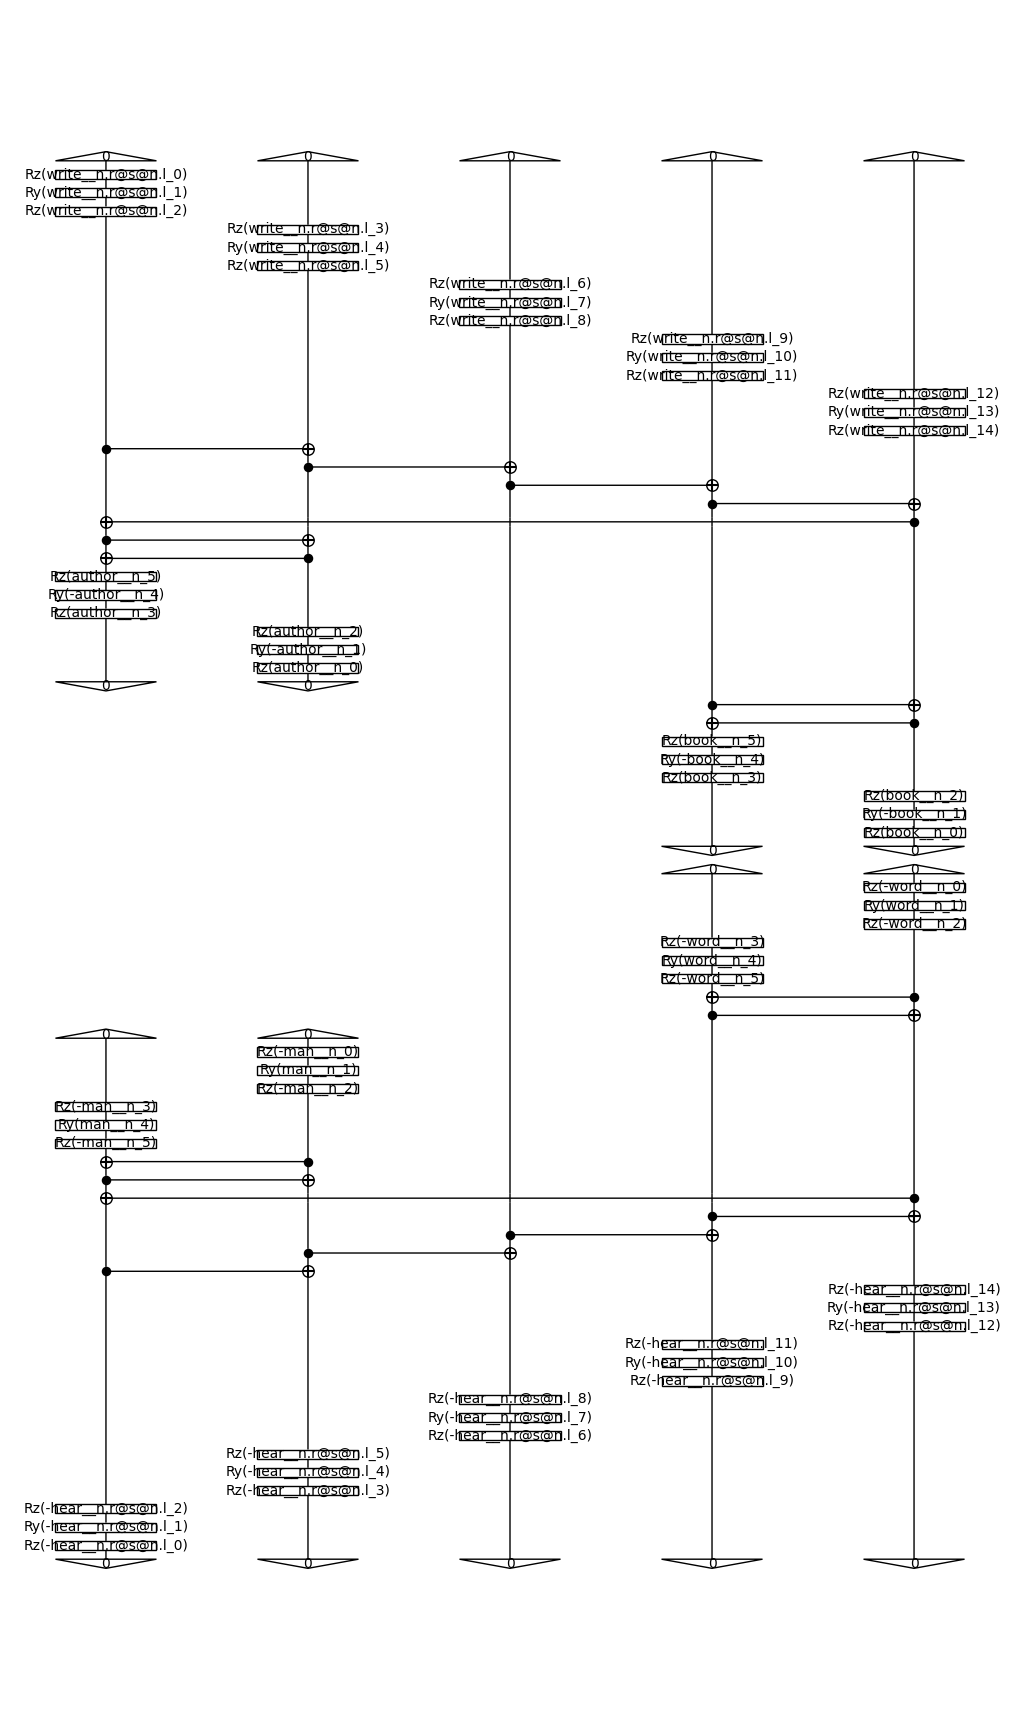

In [66]:
def diagram_to_sentence(word_list):
    n, s = Ty('n'), Ty('s')

    words = [
        Word(word_list[0], n),
        Word(word_list[1], n.r @ s @ n.l),
        Word(word_list[2], n)
    ]

    cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

    assert Id().tensor(*words) == words[0] @ words[1] @ words[2]
    assert Ty().tensor(*[n.r, s, n.l]) == n.r @ s @ n.l

    diagram = Id().tensor(*words) >> cups
    return diagram

def make_diagrams(data,row1, row2=None, drawing=False):
    if not row2:
        row2=row1
    sentence1 = data['subject'+str(1)][row1] + " " + data['verb'+str(1)][row1]  + " " + data['object'+str(1)][row1] 
    sentence2 = data['subject'+str(2)][row2] + " " + data['verb'+str(2)][row2]  + " " + data['object'+str(2)][row2] 
    
    diagram1 = diagram_to_sentence(sentence1.split(" "))
    diagram1 = remove_cups(diagram1)
    #diagram1.draw(figsize=(5, 3))
    diagram2 = diagram_to_sentence(sentence2.split(" "))
    diagram2 = remove_cups(diagram2)
    
    if drawing:
        diagram1.draw(figsize=(14,3), fontsize=12)
    return diagram1, diagram2

def make_circuit_from_diagrams(diagram1, diagram2, drawing=False, qubits_noun=2, qubits_subject=2, upload_count=1):
    N = AtomicType.NOUN
    S = AtomicType.SENTENCE

    # Convert string diagram to quantum circuit
    ansatz = StronglyEntanglingAnsatz({N: qubits_noun, S: qubits_subject}, n_layers=upload_count)

    discopy_circuit1 = ansatz(diagram1)
    #discopy_circuit1.draw(figsize=(12, 13))
    discopy_circuit2 = ansatz(diagram2)
    discopy_circuit2 = discopy_circuit2.dagger()

    discopy_circuit = discopy_circuit1 >> discopy_circuit2

    #Remove if neccessary...Encode vector into rotation gates
    #num_params = len(vector)
    #for i in range(num_params):
    #    qml.CNOT(wires=[i, i+1])
    #    qml.RX(vector[i][0], wires=i)

    if drawing:
        discopy_circuit.draw(figsize=(15, 10))

    pennylane_circuit = discopy_circuit.to_pennylane()

    return pennylane_circuit, discopy_circuit

def make_circuit_from_data(data, row_number, NOUN_QUBIT_COUNT, VERB_QUBIT_COUNT):
    diagram1, diagram2 = make_diagrams(data, row_number)
    qml_circuit, discopy_circuit = make_circuit_from_diagrams(diagram1, diagram2, False, NOUN_QUBIT_COUNT, VERB_QUBIT_COUNT, upload_count=1)
    return qml_circuit, discopy_circuit
    

make_circuit_from_data(grouped_data, 3, 2, 1)[1].draw(figsize=(10, 17))

In [19]:
make_circuit_from_data(grouped_data, 3, 1,2)[1].free_symbols

{author__n_0,
 author__n_1,
 author__n_2,
 book__n_0,
 book__n_1,
 book__n_2,
 hear__n.r@s@n.l_0,
 hear__n.r@s@n.l_1,
 hear__n.r@s@n.l_2,
 man__n_0,
 man__n_1,
 man__n_2,
 word__n_0,
 word__n_1,
 word__n_2,
 write__n.r@s@n.l_0,
 write__n.r@s@n.l_1,
 write__n.r@s@n.l_2}

# Classically Simulated Quantum Model

No input of our classically learnt parameters yet, this is just an attempt to get the circuit learnt. I will overwrite the initialise_weights() function to add in the parameters in future.

In [26]:
BATCH_SIZE = 2
EPOCHS = 2000
SEED = 42
np.random.seed(SEED) #Ran once so that we do not repeat numbers

OPTIMIZER_PARAM = {'a': 0.75, 'c': 0.1, 'A':0.01*EPOCHS}
NOUN_QUBIT_COUNT = 1
VERB_QUBIT_COUNT = 3
MOST_ACCURATE_MODEL = 384
string_identifier = str(NOUN_QUBIT_COUNT)+'_'+str(VERB_QUBIT_COUNT) +'_'+str(EPOCHS)+'_'+str(BATCH_SIZE)+'_'+ str(SEED)+"_"+'_'.join(str(obj) for obj in [str(i) for i in OPTIMIZER_PARAM.values()])

epoch_count = np.array([i for i in range(0, EPOCHS)])

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

def free_symbols_to_rotations(symbols):
    noun_parameters = 3 if NOUN_QUBIT_COUNT == 1 else (NOUN_QUBIT_COUNT-1)
    subject_parameters = NOUN_QUBIT_COUNT + NOUN_QUBIT_COUNT + VERB_QUBIT_COUNT - 1

    weights = np.zeros(shape=(len(symbols)))
    for i, word_symbol in enumerate(symbols):
        word = word_symbol.name.split("_")
        word_string = word[0]
        word_type = word[-2]
        if word_type == "n":
            word_dims = noun_parameters
        elif "@" in word_type:
            word_dims = subject_parameters #Dynamically calc these later 
        word_index = int(word[-1])
        weights[i] = word_vector_dict[word_string]['pca_'+str(word_dims)][word_index]/(2*np.pi)
    return weights

def normal_distribution_to_rotations(symbols):
    noun_parameters = 3 if NOUN_QUBIT_COUNT == 1 else (NOUN_QUBIT_COUNT-1)
    subject_parameters = NOUN_QUBIT_COUNT + NOUN_QUBIT_COUNT + VERB_QUBIT_COUNT - 1

    weights = np.zeros(shape=(len(symbols)))
    for i, word_symbol in enumerate(symbols):
        word = word_symbol.name.split("_")
        word_string = word[0]
        word_index = int(word[-1])
        word_type = word[-2]
        if word_type == "n":
            word_dims = noun_parameters
        elif "@" in word_type:
            word_dims = subject_parameters #Dynamically calc these later 

        mean_of_word = word_vector_dict[word_string][MOST_ACCURATE_MODEL].mean()
        std_of_word = word_vector_dict[word_string][MOST_ACCURATE_MODEL].std()
        
        s = np.random.normal(mean_of_word, std_of_word, 1)

        weights[i] = s
    return weights


def plot_model_over_training(model):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.figsize=(30,15)

    ax1.scatter(model.val_costs,model.train_epoch_costs,c=epoch_count, cmap='gray')
    ax1.set_xlabel("Validation Loss")
    ax1.set_ylabel("Training Loss")
    ax1.set_title("Loss of Validation and Training, should be a nice curve")
    #fig.colorbar(im = ax1.scatter, ax=ax1)

    ax2.set_title("Train & Val Losses")
    ax2.plot(epoch_count, model.val_costs, label = 'Validate')
    ax2.plot(epoch_count, model.train_epoch_costs, label = 'Train')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    fig.show()

class R2Loss(LossFunction):
    def calculate_loss(self,
                       y_pred: np.ndarray | jnp.ndarray,
                       y_true: np.ndarray | jnp.ndarray) -> float:

        self._match_shapes(y_pred, y_true)
        n_features = 2 * (3 if NOUN_QUBIT_COUNT == 1 else (NOUN_QUBIT_COUNT-1)) + (NOUN_QUBIT_COUNT + NOUN_QUBIT_COUNT + VERB_QUBIT_COUNT - 1)

        n = len(y_true)
        numerator = np.sum((y_true - y_pred) ** 2)
        denominator = np.sum((y_true - np.mean(y_true)) ** 2) + 1e-10
        r2 = 1 - (numerator / denominator)
       
        adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_features - 1))
        return adjusted_r2

## Data

In [27]:
labels = grouped_data['score']

training = pd.read_csv("Data/TrainingData.txt")
test = pd.read_csv("Data/TestData.txt")

train_data =  [make_circuit_from_data(training, i, NOUN_QUBIT_COUNT, VERB_QUBIT_COUNT)[1] for i in range(len(training))]
train_labels = labels[training['Unnamed: 0'].values]
val_data = [make_circuit_from_data(test, i, NOUN_QUBIT_COUNT, VERB_QUBIT_COUNT)[1] for i in range(len(test))] 
val_labels = labels[test['Unnamed: 0'].values]

diagrams = train_data + val_data

train_dataset = Dataset(train_data,train_labels,batch_size=BATCH_SIZE)
val_dataset = Dataset(val_data, val_labels, batch_size=BATCH_SIZE)

In [28]:
# Overlap of training and Test data
training_words = []
for circuit in train_data:
    for parameter in circuit.free_symbols:
        training_words.append(parameter.name.split("_")[0])
training_words = np.array(training_words)

validate_words = []
for circuit in val_data:
    for parameter in circuit.free_symbols:
        validate_words.append(parameter.name.split("_")[0])
validate_words = np.array(validate_words)

validate_words= set(np.unique(validate_words))
training_words = set(np.unique(training_words))
print("%/ of validation words in training words",  len(validate_words.intersection(training_words))/len(validate_words))

%/ of validation words in training words 0.9928571428571429


In [29]:
free_symbols_to_rotations(train_dataset.data[10].free_symbols), normal_distribution_to_rotations(train_dataset.data[10].free_symbols)

(array([ 0.28369826,  0.10191763,  0.38014417, ...,  0.44616722,
        -0.25321448,  0.22394464]),
 array([ 0.19988978, -0.05247445,  0.25664602, ...,  0.13535986,
        -0.39616522, -0.61268889]))

# Define Models

In [30]:
EVAL_FUNCTIONS = {'r2': R2Loss()}

class QuantumEncodedNumpyModel(NumpyModel):#Rename to "EncodedNumpyModel"
     def initialise_weights(self) -> None:
        """Initialise the weights of the model.

        Raises
        ------
        ValueError
            If `model.symbols` are not initialised.

        """
        if self.type_of_encoding == "pca":
            if not self.symbols:
                raise ValueError('Symbols not initialised. Instantiate through '
                                '`from_diagrams()`.')
            self.weights = free_symbols_to_rotations(self.symbols)

        if self.type_of_encoding == "normal_distribution":
            if not self.symbols:
                raise ValueError('Symbols not initialised. Instantiate through '
                                '`from_diagrams()`.')
            self.weights = normal_distribution_to_rotations(self.symbols)

In [34]:
random_model = NumpyModel.from_diagrams(diagrams, use_jit=True)
random_trainer = QuantumTrainer(
    random_model,
    loss_function=MSELoss(),
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams=OPTIMIZER_PARAM,
    evaluate_functions=EVAL_FUNCTIONS,
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

pca_model = QuantumEncodedNumpyModel.from_diagrams(diagrams, use_jit=True)
pca_model.type_of_encoding = 'pca'
pca_model.initialise_weights()
pca_trainer = QuantumTrainer(
    pca_model,
    loss_function=MSELoss(),
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams=OPTIMIZER_PARAM,
    evaluate_functions=EVAL_FUNCTIONS,
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

normal_model = QuantumEncodedNumpyModel.from_diagrams(diagrams, use_jit=True)
normal_model.type_of_encoding = 'normal_distribution' 
normal_model.initialise_weights()
normal_trainer = QuantumTrainer(
    normal_model,
    loss_function=MSELoss(),
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams=OPTIMIZER_PARAM,
    evaluate_functions=EVAL_FUNCTIONS,
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

## Random Model

In [ ]:
random_trainer.fit(train_dataset, val_dataset, logging_step=100)
random_model.save("random_model/random_model_"+string_identifier+".lt")

np.save('random_model/train_path_'+string_identifier+'.npy', random_trainer.train_epoch_costs)
np.save('random_model/val_path_'+string_identifier+'.npy', random_trainer.val_costs)
plot_model_over_training(random_trainer)

In [ ]:
#random_trainer.fit(train_dataset, val_dataset, logging_step=100)
#random_model.save("random_model/random_model_"+string_identifier+".lt")

#np.save('random_model/train_path_'+string_identifier+'.npy', random_trainer.train_epoch_costs)
#np.save('random_model/val_path_'+string_identifier+'.npy', random_trainer.val_costs)


random_trainer.val_costs

#plot_model_over_training(random_trainer)

In [ ]:
random_trainer.fit(train_dataset, val_dataset, logging_step=100)
random_model.save("random_model/random_model_"+string_identifier+".lt")

np.save('random_model/train_path_'+string_identifier+'.npy', random_trainer.train_epoch_costs)
np.save('random_model/val_path_'+string_identifier+'.npy', random_trainer.val_costs)
plot_model_over_training(random_trainer)

C:\Users\henry\AppData\Local\Temp\ipykernel_100740\331374358.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


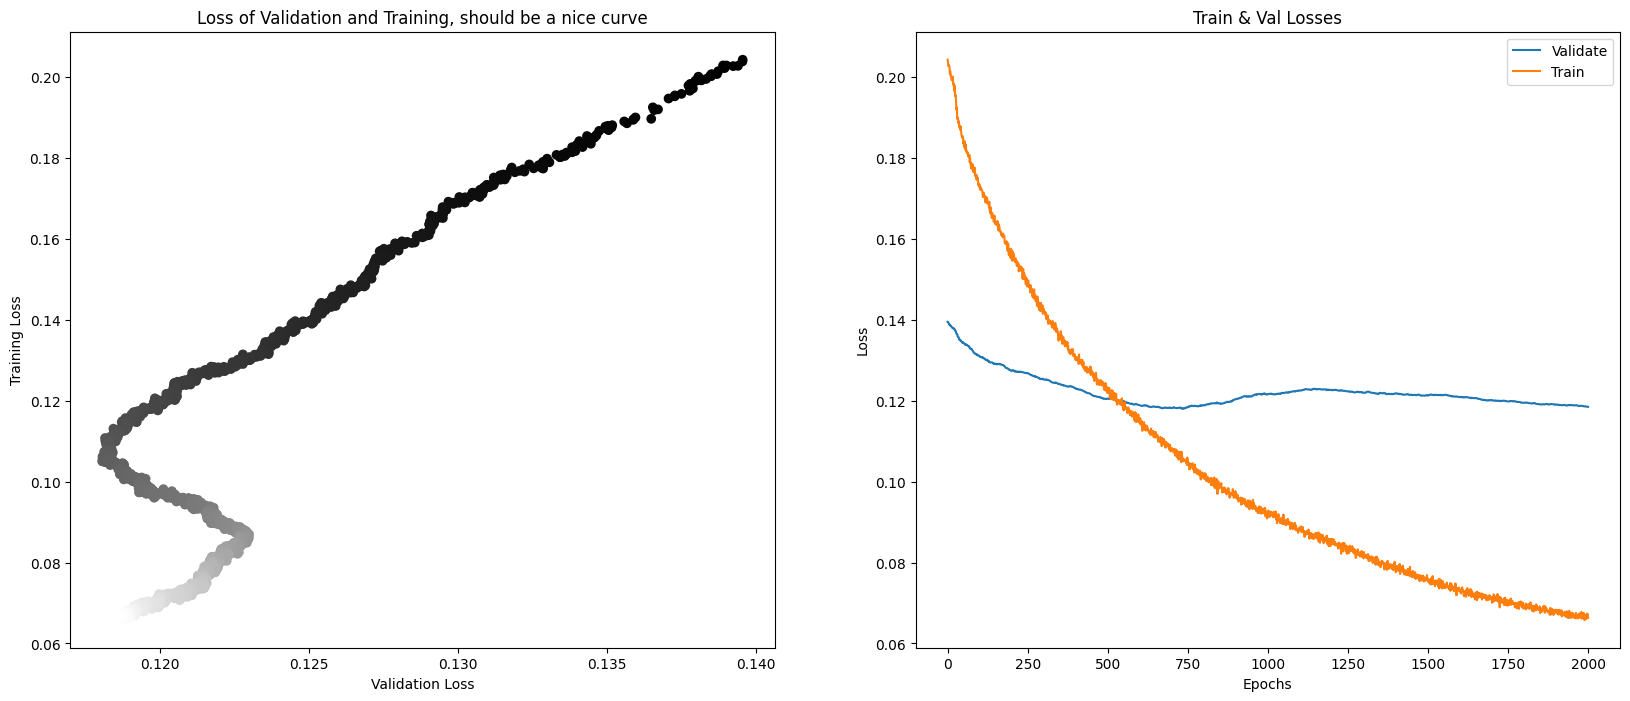

In [ ]:
plot_model_over_training(random_trainer)

# Encoded Model

In [27]:
pca_trainer.fit(train_dataset, val_dataset, logging_step=100)

pca_model.save("pca_model/pca_model_"+string_identifier+".lt")

np.save('pca_model/train_path_'+string_identifier+'.npy', pca_trainer.train_epoch_costs)
np.save('pca_model/val_path_'+string_identifier+'.npy', pca_trainer.val_costs)

Epoch 1:     train/loss: 0.1984   valid/loss: 0.1197   train/r2: 4528940.0000   valid/r2: 78.9394
Epoch 100:   train/loss: 0.1080   valid/loss: 0.0904   train/r2: 11.4300   valid/r2: 21285514.0000
Epoch 200:   train/loss: 0.0717   valid/loss: 0.0824   train/r2: 245.6242   valid/r2: 1105.5718
Epoch 300:   train/loss: 0.0537   valid/loss: 0.0809   train/r2: 5.2065   valid/r2: 6671.7114


KeyboardInterrupt: 

In [159]:
#OLD VERSION, WORKED!

pca_trainer.fit(train_dataset, val_dataset, logging_step=100)

pca_model.save("pca_model/pca_model_"+string_identifier+".lt")

np.save('pca_model/train_path_'+string_identifier+'.npy', pca_trainer.train_epoch_costs)
np.save('pca_model/val_path_'+string_identifier+'.npy', pca_trainer.val_costs)

Epoch 1:     train/loss: 0.1987   valid/loss: 0.1218   train/r2: 915941.8125   valid/r2: 22.4370
Epoch 100:   train/loss: 0.1077   valid/loss: 0.0873   train/r2: 22.1338   valid/r2: 12.4695
Epoch 200:   train/loss: 0.0644   valid/loss: 0.0819   train/r2: 72.6251   valid/r2: 2088.0977
Epoch 300:   train/loss: 0.0419   valid/loss: 0.0853   train/r2: 50.6227   valid/r2: 46.2277
Epoch 400:   train/loss: 0.0332   valid/loss: 0.0867   train/r2: 4.1969   valid/r2: 708.8431
Epoch 500:   train/loss: 0.0259   valid/loss: 0.0862   train/r2: 4.0799   valid/r2: 106.1403
Epoch 600:   train/loss: 0.0229   valid/loss: 0.0865   train/r2: 133.1810   valid/r2: 7.2254
Epoch 700:   train/loss: 0.0203   valid/loss: 0.0881   train/r2: 38014.1055   valid/r2: 15.3720
Epoch 800:   train/loss: 0.0190   valid/loss: 0.0877   train/r2: 1.6307   valid/r2: 426.5564
Epoch 900:   train/loss: 0.0168   valid/loss: 0.0883   train/r2: 37.9577   valid/r2: 14320723.0000
Epoch 1000:  train/loss: 0.0159   valid/loss: 0.0882   

C:\Users\henry\AppData\Local\Temp\ipykernel_100740\331374358.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


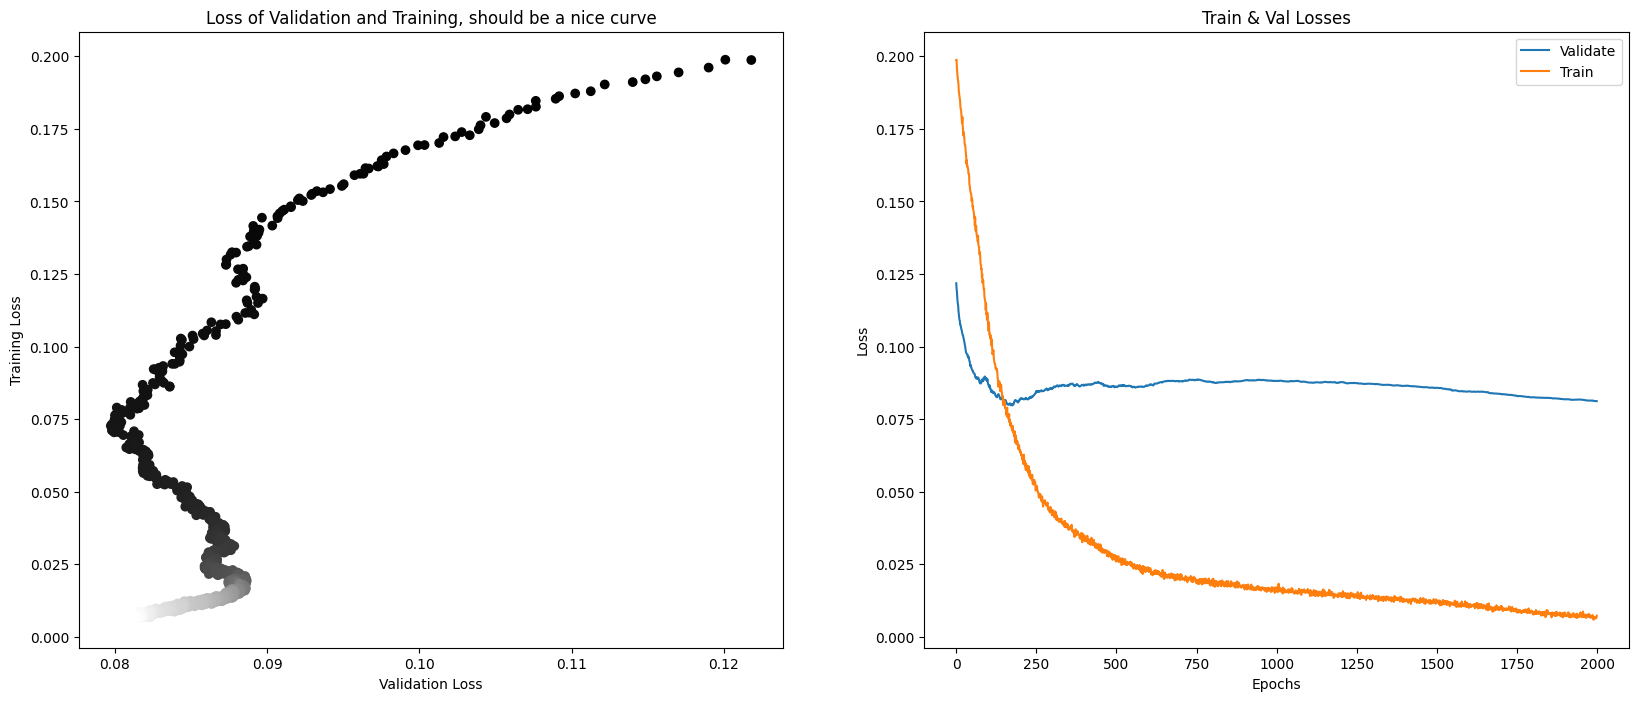

In [160]:
plot_model_over_training(pca_trainer)

## Normal Distribution around best-BERT model

In [161]:
normal_trainer.fit(train_dataset, val_dataset, logging_step=100)
normal_model.save("normal_model/normal_model_"+string_identifier+".lt")

np.save('normal_model/train_path_'+string_identifier+'.npy', normal_trainer.train_epoch_costs)
np.save('normal_model/val_path_'+string_identifier+'.npy', normal_trainer.val_costs)

Epoch 1:     train/loss: 0.2013   valid/loss: 0.1410   train/r2: 20.1464   valid/r2: 6546.5649
Epoch 100:   train/loss: 0.1482   valid/loss: 0.1310   train/r2: 48183616.0000   valid/r2: 2719458.0000
Epoch 200:   train/loss: 0.1253   valid/loss: 0.1233   train/r2: 108.6678   valid/r2: 4.7164
Epoch 300:   train/loss: 0.1113   valid/loss: 0.1176   train/r2: 727263.0625   valid/r2: 24.0591
Epoch 400:   train/loss: 0.1026   valid/loss: 0.1135   train/r2: 701040.2500   valid/r2: 7.8639
Epoch 500:   train/loss: 0.0959   valid/loss: 0.1106   train/r2: 9.1336   valid/r2: 10.9252
Epoch 600:   train/loss: 0.0901   valid/loss: 0.1089   train/r2: 2776456.0000   valid/r2: 34.0861
Epoch 700:   train/loss: 0.0875   valid/loss: 0.1071   train/r2: 12.0333   valid/r2: 16.6049
Epoch 800:   train/loss: 0.0819   valid/loss: 0.1059   train/r2: 13.6512   valid/r2: 2884.9917
Epoch 900:   train/loss: 0.0786   valid/loss: 0.1048   train/r2: 5.3747   valid/r2: 1081.6926
Epoch 1000:  train/loss: 0.0752   valid/los

C:\Users\henry\AppData\Local\Temp\ipykernel_100740\331374358.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


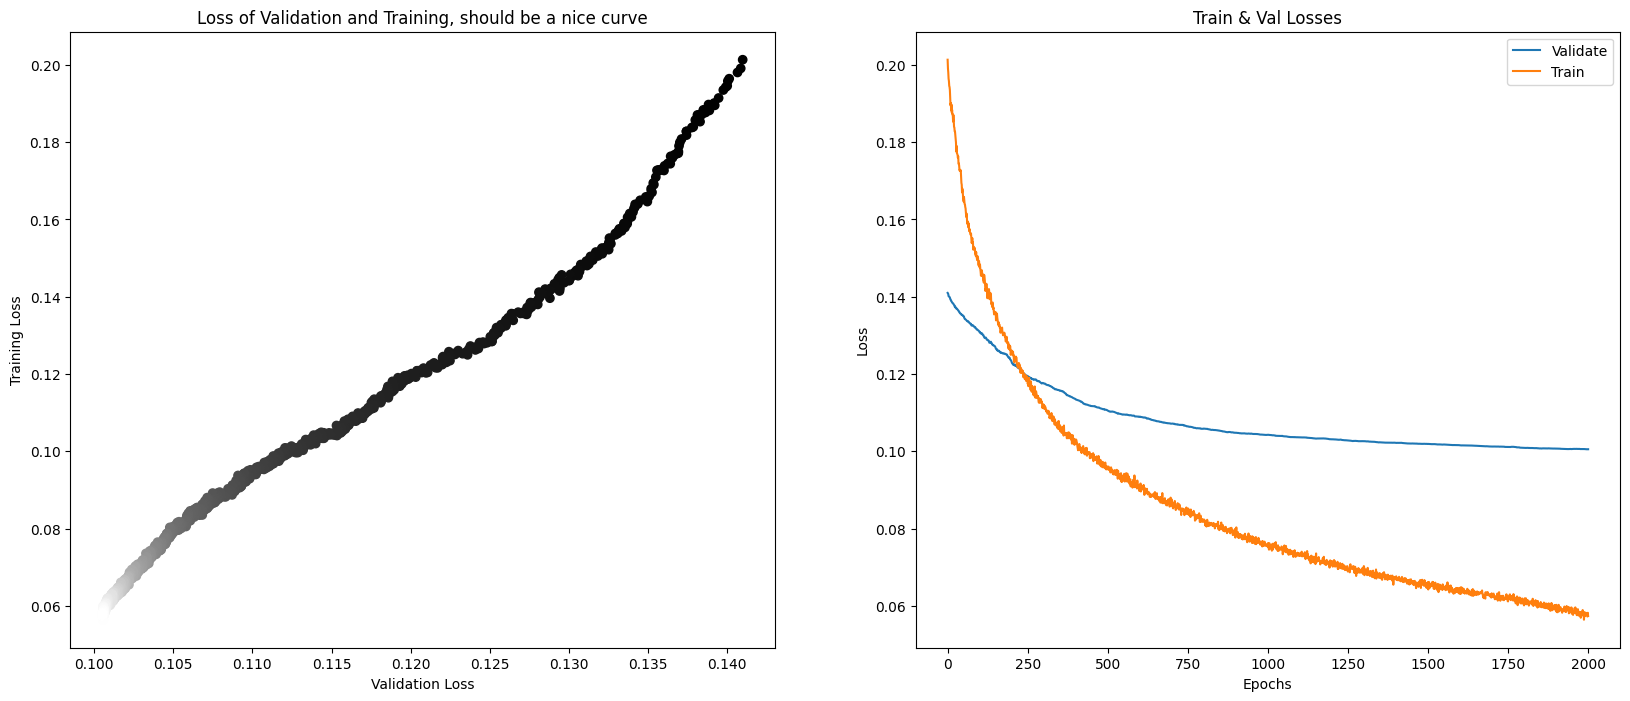

In [162]:
plot_model_over_training(normal_trainer)

## Compare

In [164]:
random_model = NumpyModel.from_checkpoint('random_model/random_model_'+string_identifier+'.lt')
random_trainer_val_costs = np.load('random_model/val_path_'+string_identifier+'.npy')
random_trainer_train_costs = np.load('random_model/train_path_'+string_identifier+'.npy')

pca_model = NumpyModel.from_checkpoint('pca_model/pca_model_'+string_identifier+'.lt')
pca_trainer_val_costs = np.load('pca_model/val_path_'+string_identifier+'.npy')
pca_trainer_train_costs = np.load('pca_model/train_path_'+string_identifier+'.npy')

normal_model = NumpyModel.from_checkpoint('normal_model/normal_model_'+string_identifier+'.lt')
normal_trainer_val_costs = np.load('normal_model/val_path_'+string_identifier+'.npy')
normal_trainer_train_costs = np.load('normal_model/train_path_'+string_identifier+'.npy')

In [165]:
random_prediction = pd.Series(random_model.get_diagram_output(diagrams))
e_prediction = pd.Series(pca_model.get_diagram_output(diagrams))
normal_prediction = pd.Series(normal_model.get_diagram_output(diagrams))

print("encoded correlation: {}, random correlation: {}, normal dist correlations: {}".format(
    grouped_data['score'].corr(e_prediction, method='spearman'), 
    grouped_data['score'].corr(random_prediction, method='spearman'), 
    grouped_data['score'].corr(normal_prediction, method='spearman')))

encoded correlation: 0.0022584765199451552, random correlation: 0.02480035925382813, normal dist correlations: 0.03651680179084319


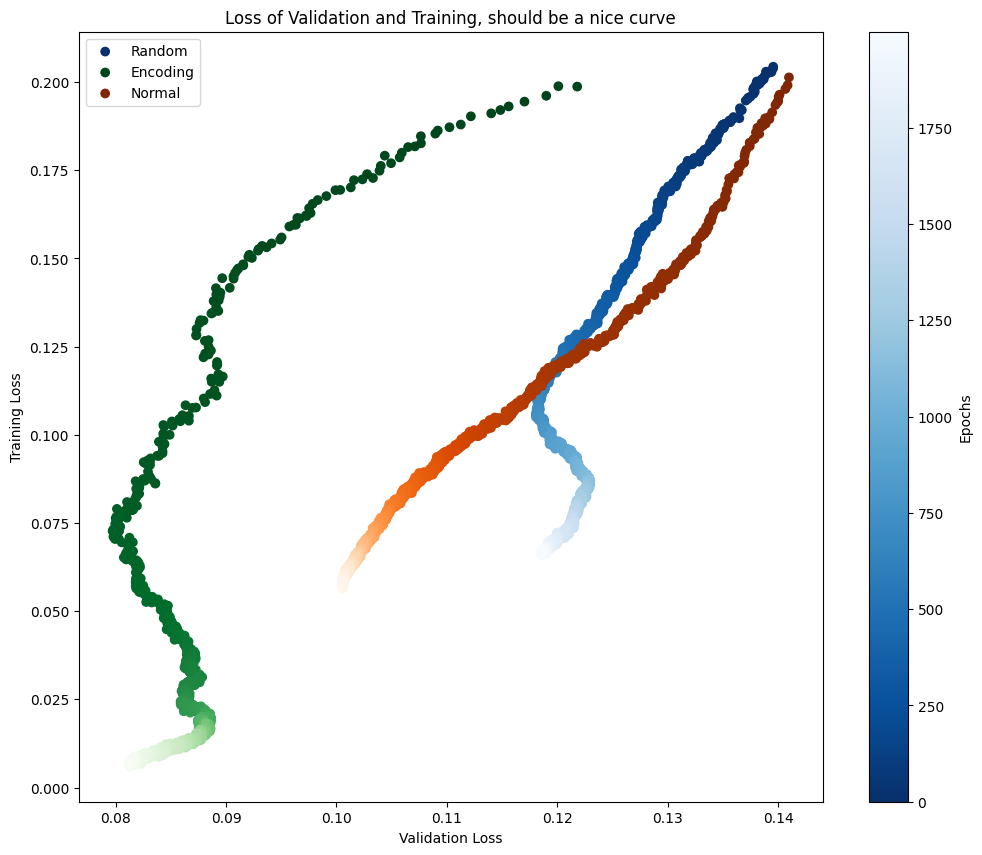

In [166]:
ax = plt.figure(figsize=(12,10))
plt.scatter(random_trainer_val_costs,random_trainer_train_costs,c=epoch_count, cmap='Blues_r', label = 'Random')
plt.colorbar(label='Epochs')
plt.scatter(pca_trainer_val_costs,pca_trainer_train_costs,c=epoch_count, cmap='Greens_r', label = 'Encoding')
plt.scatter(normal_trainer_val_costs,normal_trainer_train_costs,c=epoch_count, cmap='Oranges_r', label = 'Normal')
plt.xlabel("Validation Loss")
plt.ylabel("Training Loss")
plt.title("Loss of Validation and Training, should be a nice curve")

plt.legend()

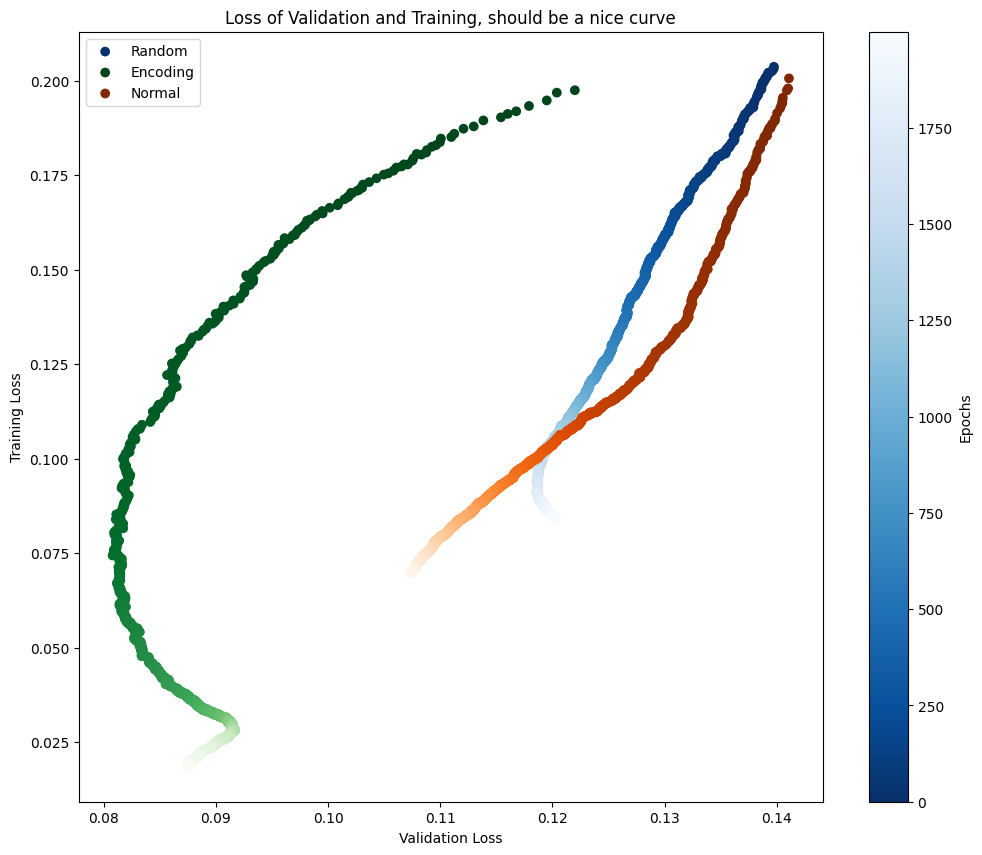

In [89]:
ax = plt.figure(figsize=(12,10))
plt.scatter(random_trainer_val_costs,random_trainer_train_costs,c=epoch_count, cmap='Blues_r', label = 'Random')
plt.colorbar(label='Epochs')
plt.scatter(pca_trainer_val_costs,pca_trainer_train_costs,c=epoch_count, cmap='Greens_r', label = 'Encoding')
plt.scatter(normal_trainer_val_costs,normal_trainer_train_costs,c=epoch_count, cmap='Oranges_r', label = 'Normal')
plt.xlabel("Validation Loss")
plt.ylabel("Training Loss")
plt.title("Loss of Validation and Training, should be a nice curve")

plt.legend()

## Repeating for lower EPOCHS:

In [52]:
EPOCHS = 300

from lambeq import QuantumTrainer, SPSAOptimizer, NumpyModel, MSELoss

lower_epoch_numpy_model = NumpyModel.from_diagrams(diagrams, use_jit=True)
mse = MSELoss()

lower_epoch_numpy_trainer = QuantumTrainer(
    lower_epoch_numpy_model,
    loss_function=mse,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.5, 'c': 0.10, 'A':0.01*EPOCHS},
    evaluate_functions={'mse': MSELoss()},
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED+1
)
lower_epoch_numpy_trainer.fit(train_dataset, val_dataset, logging_step=100)

Epoch 1:    train/loss: 0.1867   valid/loss: 0.1223   train/mse: 0.1837   valid/mse: 0.1223
Epoch 100:  train/loss: 0.1079   valid/loss: 0.1126   train/mse: 0.1055   valid/mse: 0.1126
Epoch 200:  train/loss: 0.0862   valid/loss: 0.1069   train/mse: 0.0819   valid/mse: 0.1069
Epoch 300:  train/loss: 0.0763   valid/loss: 0.1054   train/mse: 0.0748   valid/mse: 0.1054

Training completed!


In [53]:
mse = MSELoss()

lower_epoch_numpy_e_model = QuantumEncodedNumpyModel.from_diagrams(diagrams, use_jit=True)
lower_epoch_numpy_e_model.initialise_weights()

lower_epoch_numpy_e_trainer = QuantumTrainer(
    lower_epoch_numpy_e_model,
    loss_function=mse,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.5, 'c': 0.10, 'A':0.01*EPOCHS},
    evaluate_functions={'mse': MSELoss()},
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED+1
)
lower_epoch_numpy_e_trainer.fit(train_dataset, val_dataset, logging_step=100)

Epoch 1:    train/loss: 0.1910   valid/loss: 0.1261   train/mse: 0.1893   valid/mse: 0.1261
Epoch 100:  train/loss: 0.1216   valid/loss: 0.1040   train/mse: 0.1180   valid/mse: 0.1040
Epoch 200:  train/loss: 0.0961   valid/loss: 0.0985   train/mse: 0.0935   valid/mse: 0.0985
Epoch 300:  train/loss: 0.0776   valid/loss: 0.0972   train/mse: 0.0809   valid/mse: 0.0972

Training completed!


ValueError: 'c' argument has 300 elements, which is inconsistent with 'x' and 'y' with size 2000.

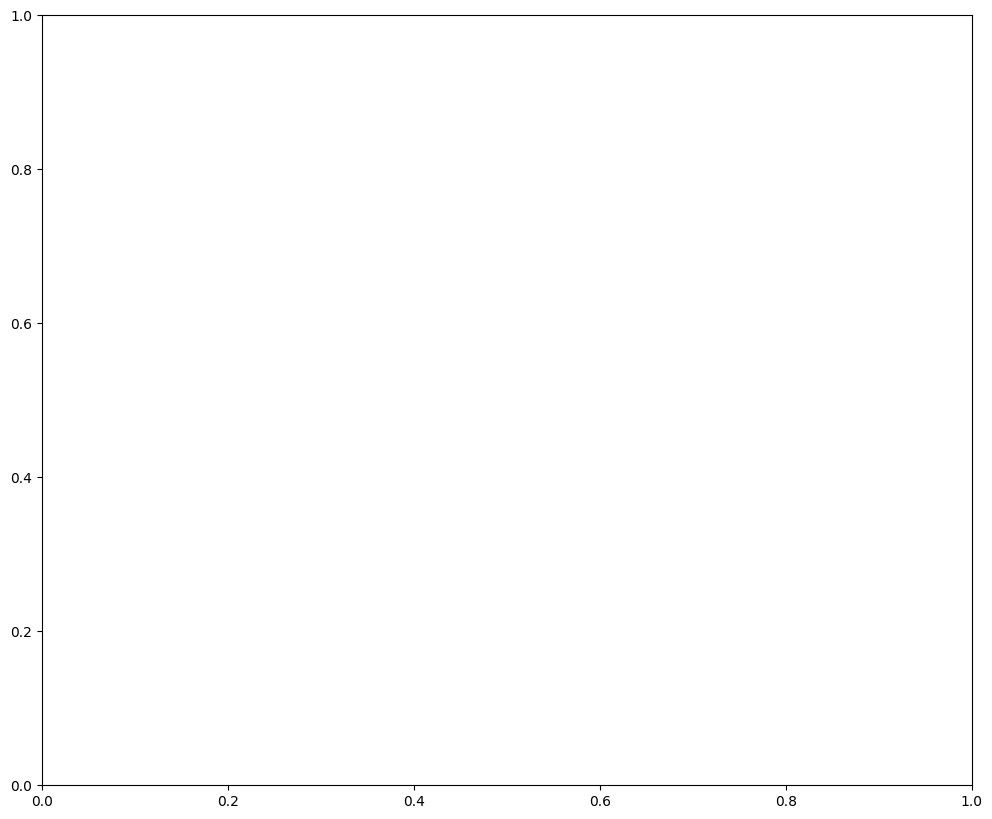

In [54]:
ax = plt.figure(figsize=(12,10))
plt.scatter(numpy_trainer.val_costs,numpy_trainer.train_epoch_costs,c=range(EPOCHS), cmap='Blues_r', label = 'Random')
plt.colorbar(label='Epochs')
plt.scatter(numpy_e_trainer.val_costs,numpy_e_trainer.train_epoch_costs,c=range(EPOCHS), cmap='Greens_r', label = 'Encoding')
plt.xlabel("Validation Loss")
plt.ylabel("Training Loss")
plt.title("Loss of Validation and Training, should be a nice curve")
plt.colorbar()
plt.legend()

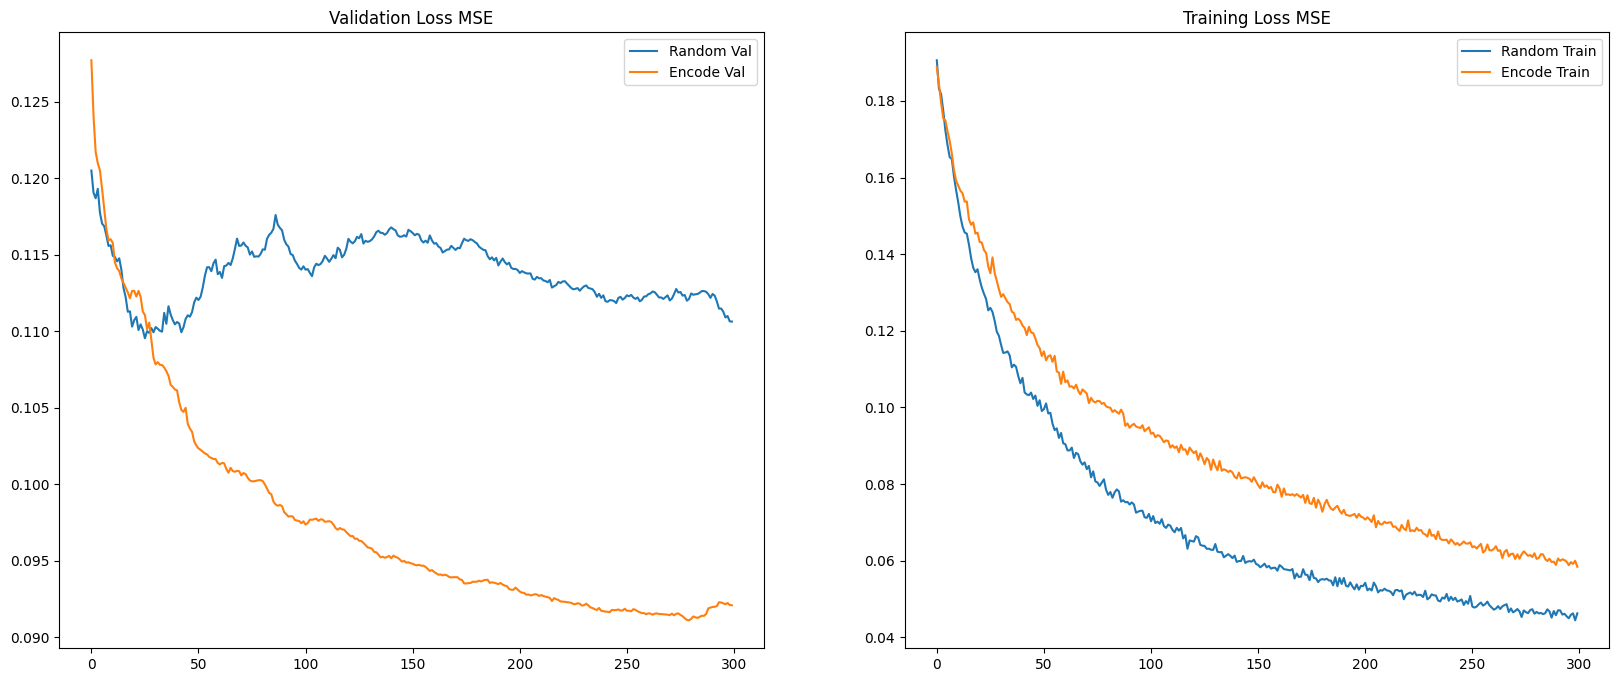

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.figsize=(30,15)

ax1.set_title("Validation Loss MSE")
ax1.plot(range(EPOCHS), numpy_trainer.val_costs, label = 'Random Val')
ax1.plot(range(EPOCHS), numpy_e_trainer.val_costs, label = 'Encode Val')
ax1.legend()

ax2.set_title("Training Loss MSE")
ax2.plot(range(EPOCHS), numpy_trainer.train_epoch_costs, label = 'Random Train')
ax2.plot(range(EPOCHS), numpy_e_trainer.train_epoch_costs, label = 'Encode Train')
ax2.legend()


## Pennylane Model

In [45]:
pennylane_model = PennyLaneModel.from_diagrams(diagrams, normalize=False)

pennylane_model.initialise_weights()

Can quantum computers learn sentence embeddings from dimensionality-reduced, classically-learnt word embeddings using the DisCoCat framework? 

In [46]:
def custom_cosine(y_hat, y):
    a_y_hat = y_hat.reshape(-1,1)
    a_y = y.reshape(-1,1)
    return torch.nn.functional.cosine_similarity(a_y_hat, a_y)
	#return torch.nn.functional.cosine_embedding_loss(a_y_hat, a_y)

pennylane_trainer = PytorchTrainer(
    model=pennylane_model,
    loss_function=torch.nn.functional.mse_loss, #
    optimizer=torch.optim.SGD , # Use SPSA, SGD
    learning_rate=2.5,
    epochs=EPOCHS,
    evaluate_functions={'mse': torch.nn.functional.mse_loss,'l1_loss':torch.nn.functional.l1_loss, 'poisson_nll':torch.nn.functional.poisson_nll_loss},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

pennylane_trainer.fit(train_dataset, val_dataset, logging_step=15)

Epoch 1:    train/loss: 0.1870   valid/loss: 0.1198   train/mse: 0.1870   train/l1_loss: 0.3565   train/poisson_nll: 1.0241   valid/mse: 0.1198   valid/l1_loss: 0.2768   valid/poisson_nll: 1.0380
Epoch 15:   train/loss: 0.1295   valid/loss: 0.1096   train/mse: 0.1295   train/l1_loss: 0.2863   train/poisson_nll: 1.0665   valid/mse: 0.1096   valid/l1_loss: 0.2531   valid/poisson_nll: 1.0571
Epoch 30:   train/loss: 0.1284   valid/loss: 0.1074   train/mse: 0.1284   train/l1_loss: 0.2810   train/poisson_nll: 1.0720   valid/mse: 0.1074   valid/l1_loss: 0.2485   valid/poisson_nll: 1.0611
Epoch 45:   train/loss: 0.1268   valid/loss: 0.1087   train/mse: 0.1268   train/l1_loss: 0.2783   train/poisson_nll: 1.0733   valid/mse: 0.1087   valid/l1_loss: 0.2498   valid/poisson_nll: 1.0607
Epoch 60:   train/loss: 0.1270   valid/loss: 0.1093   train/mse: 0.1270   train/l1_loss: 0.2778   train/poisson_nll: 1.0743   valid/mse: 0.1093   valid/l1_loss: 0.2545   valid/poisson_nll: 1.0559
Epoch 75:   train/lo

In [47]:
epoch_count = [i for i in range(0, EPOCHS)]
len(epoch_count)

300

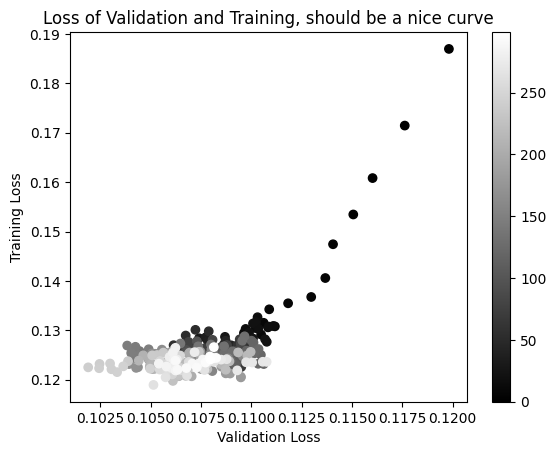

In [48]:
plt.scatter(trainer.val_costs,trainer.train_epoch_costs, c = epoch_count, cmap='gray')
plt.xlabel("Validation Loss")
plt.ylabel("Training Loss")
plt.title("Loss of Validation and Training, should be a nice curve")
plt.colorbar()

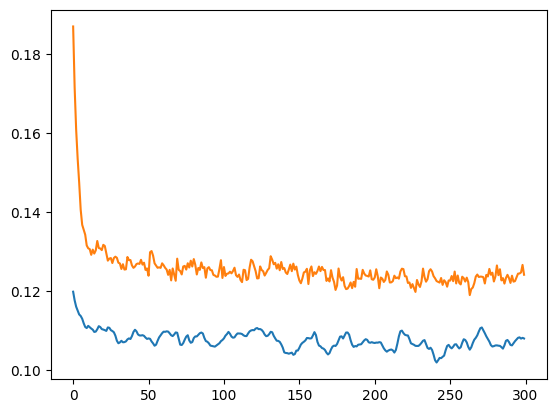

In [49]:
plt.plot(epoch_count, trainer.val_costs)
plt.plot(epoch_count, trainer.train_epoch_costs)

# My Encoding

In [ ]:
class ClassicalUploadPennyLaneModel(PennyLaneModel):
    def initialise_weights(self, vector) -> None:
        """Initialise the weights of the model.
        Parameters
        ----------
        vector : list or numpy.ndarray or torch.Tensor
            1D array of numbers between [0-1] to be used as weights.
        Raises
        ------
        ValueError
            If `model.symbols` are not initialised.
        """
        self._reinitialise_modules()
        if not self.symbols:
            raise ValueError('Symbols not initialised. Instantiate through '
                             '`PennyLaneModel.from_diagrams()`.')

        vector_tensor = torch.tensor(vector).squeeze()
        self.weights = torch.nn.ParameterList([
            torch.nn.Parameter(value)
            for value in vector_tensor
        ])
        for p_circ in self.circuit_map.values():
            p_circ.initialise_concrete_params(self.symbols, self.weights)


labels = grouped_data['score']

train_data =  [make_circuit_from_data(training, i)[1] for i in range(len(training))]#diagrams[: int(0.7*number_of_data)]
train_labels = labels[training['Unnamed: 0'].values]
val_data = [make_circuit_from_data(test, i)[1] for i in range(len(test))] #diagrams[int(0.7*number_of_data):]
val_labels = labels[test['Unnamed: 0'].values]

diagrams = train_data + val_data

train_dataset = Dataset(train_data,train_labels,batch_size=BATCH_SIZE)
val_dataset = Dataset(val_data, val_labels, batch_size=BATCH_SIZE)

model = ClassicalUploadPennyLaneModel.from_diagrams(diagrams, normalize=False)

model.initialise_weights(vector)

In [ ]:
#Making the encoding vector:
qubits_per_word = 4
total_qubits = 3 * qubits_per_word
row = 0
vector = np.zeros(shape=(len(make_circuit_from_data(training, 0)[1].free_symbols), len(training)))
print(vector)
for row in range(0, len(grouped_data)):
	vector[0:2, row] = word_vector_dict[training['subject'+str(1)][row]]['pca_2']
	vector[2:8, row] = word_vector_dict[training['verb'+str(1)][row]]['pca_6']
	vector[8:10, row] = word_vector_dict[training['object'+str(1)][row]]['pca_2']
	vector[10:12, row] = word_vector_dict[training['subject'+str(1)][row]]['pca_2']
	vector[14:20, row] = word_vector_dict[training['verb'+str(1)][row]]['pca_6']
	vector[12:14, row] = word_vector_dict[training['object'+str(1)][row]]['pca_2']

for row in range(0, len(grouped_data)):
    subject_size = len(word_vector_dict[training['subject'+str(1)][row]]['pca_2'])
    verb_size = len(word_vector_dict[training['verb'+str(1)][row]]['pca_6'])
    object_size = len(word_vector_dict[training['object'+str(1)][row]]['pca_2'])
    
    vector[0:subject_size, row] = word_vector_dict[training['subject'+str(1)][row]]['pca_2']
    vector[subject_size:subject_size+verb_size, row] = word_vector_dict[training['verb'+str(1)][row]]['pca_6']
    vector[subject_size+verb_size:subject_size+verb_size+object_size, row] = word_vector_dict[training['object'+str(1)][row]]['pca_2']
    vector[subject_size+verb_size+object_size:subject_size+verb_size+object_size+subject_size, row] = word_vector_dict[training['subject'+str(1)][row]]['pca_2']
    vector[subject_size+verb_size+object_size+subject_size+2:subject_size+verb_size+object_size+subject_size+verb_size+2, row] = word_vector_dict[training['verb'+str(1)][row]]['pca_6']
    vector[subject_size+verb_size+object_size+subject_size+verb_size+2:subject_size+verb_size+object_size+subject_size+verb_size+object_size+2, row] = word_vector_dict[training['object'+str(1)][row]]['pca_2']

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


ValueError: could not broadcast input array from shape (6,) into shape (2,)

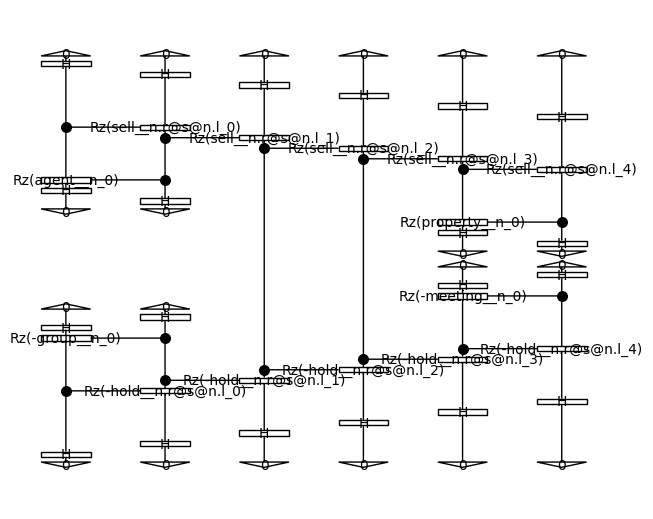

In [ ]:
make_circuit_from_data(grouped_data, 1)[1].draw(figsize=(6,5))

In [ ]:
# CHATGOT:

labels = grouped_data['score']
sentences1 = [grouped_data['subject'+str(1)], grouped_data['verb'+str(1)], grouped_data['object'+str(1)]]
sentences2 = [grouped_data['subject'+str(1)], grouped_data['verb'+str(1)], grouped_data['object'+str(1)]]

diagrams = [make_circuit_from_data(i)[1] for i in range(len(grouped_data))]

number_of_data = len(diagrams)
train_data = diagrams[: int(0.7*number_of_data)]
train_labels = labels[: int(0.7*number_of_data)]
val_data = diagrams[int(0.7*number_of_data):]
val_labels = labels[int(0.7*number_of_data):]

train_dataset = Dataset(train_data, train_labels, batch_size=BATCH_SIZE)
val_dataset = Dataset(val_data, val_labels, batch_size=BATCH_SIZE)

model = PennyLaneModel.from_diagrams(diagrams, normalize=False)
model.initialise_weights()

def custom_cosine(y_hat, y):
    a_y_hat = y_hat.reshape(-1,1)
    a_y = y.reshape(-1,1)
    return torch.nn.functional.cosine_similarity(a_y_hat, a_y)

loss_function = torch.nn.functional.mse_loss
learning_rate = 1.0
evaluate_functions = {'mse': torch.nn.functional.mse_loss, 'l1_loss': torch.nn.functional.l1_loss, 'poisson_nll': torch.nn.functional.poisson_nll_loss}
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(EPOCHS):
    # Training loop
    model.train()
    total_loss = 0
    for data, labels in train_dataset:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_train_loss = total_loss / len(train_dataset)

    # Validation loop
    model.eval()
    total_val_loss = 0
    for data, labels in val_dataset:
        with torch.no_grad():
            output = model(data)
            val_loss = loss_function(output, labels)
            total_val_loss += val_loss.item()
    average_val_loss = total_val_loss / len(val_dataset)

    # Print epoch statistics
    print(f"Epoch {epoch + 1}/{EPOCHS}: Train Loss = {average_train_loss}, Val Loss = {average_val_loss}")

    # Additional evaluation functions
    for eval_name, eval_func in evaluate_functions.items():
        train_eval = eval_func(model(train_dataset.data), train_dataset.labels)
        val_eval = eval_func(model(val_dataset.data), val_dataset.labels)
        print(f"Epoch {epoch + 1}/{EPOCHS}: Train {eval_name} = {train_eval}, Val {eval_name} = {val_eval}")

TypeError: 'int' object is not callable

# Working with grid-seacrhed mdoels

In [29]:
import os
import joblib
import numpy as np

def retrieve_model_info(model_folder_path):
    if os.path.exists(model_folder_path):
        model_params_filepath = os.path.join(model_folder_path, "model_params.joblib")
        model_params = joblib.load(model_params_filepath)
        
        training_losses_filepath = os.path.join(model_folder_path, "training_losses.npy")
        validation_losses_filepath = os.path.join(model_folder_path, "validation_losses.npy")
        training_losses = np.load(training_losses_filepath)
        validation_losses = np.load(validation_losses_filepath)
        
        folder_parts = os.path.basename(model_folder_path).split('_')
        model_type = folder_parts[0]
        ansatz_name = folder_parts[1][:-len("ansatz")]
        ansatz_hyperparams_str = [folder_parts[2][1:], folder_parts[3][1:], folder_parts[4][len("layers"):]]
        loss_name = folder_parts[5][:-len("loss")]
        optimizer_name = folder_parts[6][:-len("optimizer")]
        optimizer_hyperparams_str = [folder_parts[7][len("a"):], folder_parts[8][len("c"):], folder_parts[9][len("A"):]]
        num_epochs = int(folder_parts[10][len('epochs'):])
        batch_size = int(folder_parts[11][len('batch'):])
        seed = int(folder_parts[12][len('seed'):])
        model_info = {
            'model_type': model_type,
            'ansatz_name': ansatz_name,
            'ansatz_hyperparams_str': ansatz_hyperparams_str,
            'loss_name': loss_name,
            'optimizer_name': optimizer_name,
            'optimizer_hyperparams_str': optimizer_hyperparams_str,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'seed': seed,
            'model_params': model_params,
            'training_losses': training_losses,
            'validation_losses': validation_losses,}
        return model_info
    return None

def retrieve_all_models_info(models_directory):
    model_info_list = []
    for model_folder in os.listdir(models_directory):
        try:
            model_folder_path = os.path.join(models_directory, model_folder)
            model_info = retrieve_model_info(model_folder_path)
            if model_info:
                model_info_list.append(model_info)
        except:
            pass
    return model_info_list
models_directory = "C:/Users/henry/Desktop/MastersProject/QNLP_MasterWork/models"
all_models_info = retrieve_all_models_info(models_directory)

## SPSA Parameters

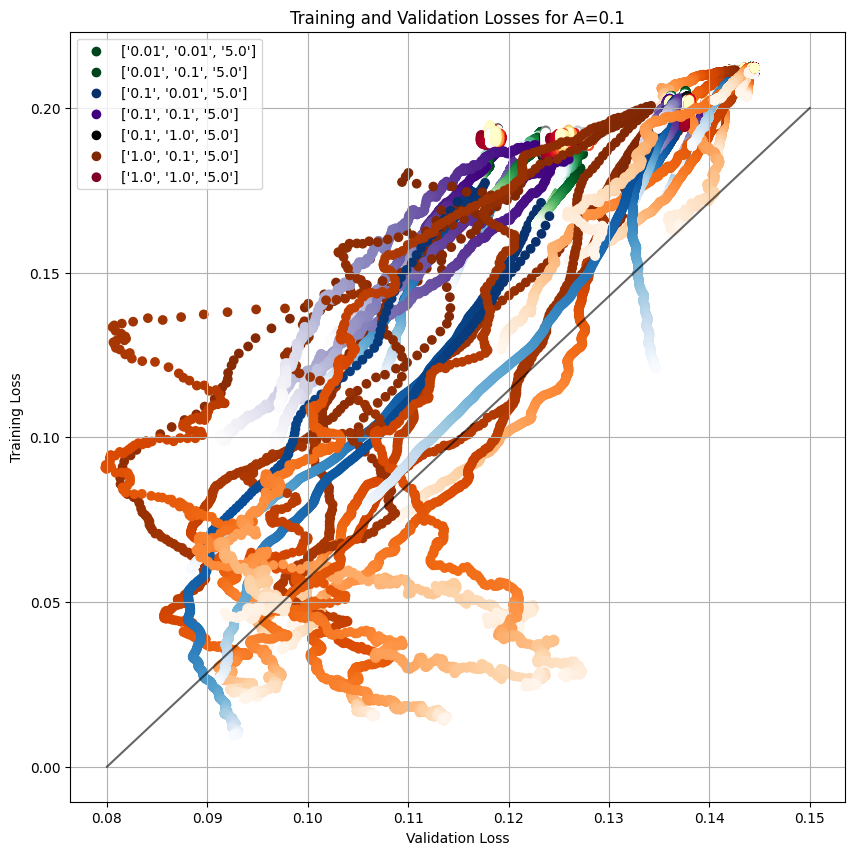

In [30]:
# Filter the models where optimizer_hyperparams_str[0] == '0.01' or '1.0'
filtered_models = [model_info for model_info in all_models_info]# if model_info['optimizer_hyperparams_str'][0] in ['0.01', '1.0']]

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Get unique values of optimizer_hyperparams_str
unique_values = [tuple(model_info['optimizer_hyperparams_str']) for model_info in filtered_models]

# Create a dictionary to map each unique combination to a color
color_map = {
    #('0.01', '0.01', '20.0'): 'PuBu_r', 
    ('0.01', '0.01', '5.0'): 'Greens_r', 
    ('0.01','0.1','5.0'): 'BuGn_r',
    ('0.1','0.01','5.0'):  'Blues_r',
    ('0.1','0.1','5.0'):  'Purples_r',
    ('1.0','0.1','5.0'):  'Oranges_r',
    ('0.1','1.0','5.0'):  'Greys_r',
    ('1.0','1.0','5.0'):  'YlOrRd_r',  
    } 
average_window = 10
fig = plt.figure(figsize=(10, 10))
added_labels = []
# Plot training and validation losses for each model in the filtered_models list
for i, model_info in enumerate(filtered_models):
    num_epochs = model_info['num_epochs']
    training_losses = model_info['training_losses']
    validation_losses = model_info['validation_losses']

    epochs = np.arange(1, num_epochs + 1 - (average_window-1))

    optimizer_param_value = tuple(model_info['optimizer_hyperparams_str'])
    cmap = color_map.get(optimizer_param_value)
    if cmap is None:
        continue
    iterations_label = model_info['optimizer_hyperparams_str'] if model_info['optimizer_hyperparams_str'] not in added_labels else None
    plt.scatter(moving_average(validation_losses, average_window), moving_average(training_losses, average_window), c=epochs, cmap=cmap, label = iterations_label)
    added_labels.append(model_info['optimizer_hyperparams_str'])

plt.plot([0.08,0.15], [0,0.2], color='k', alpha=0.6)
plt.legend()
plt.xlabel('Validation Loss')
plt.ylabel('Training Loss')
plt.title('Training and Validation Losses for A=0.1')
plt.grid(True)

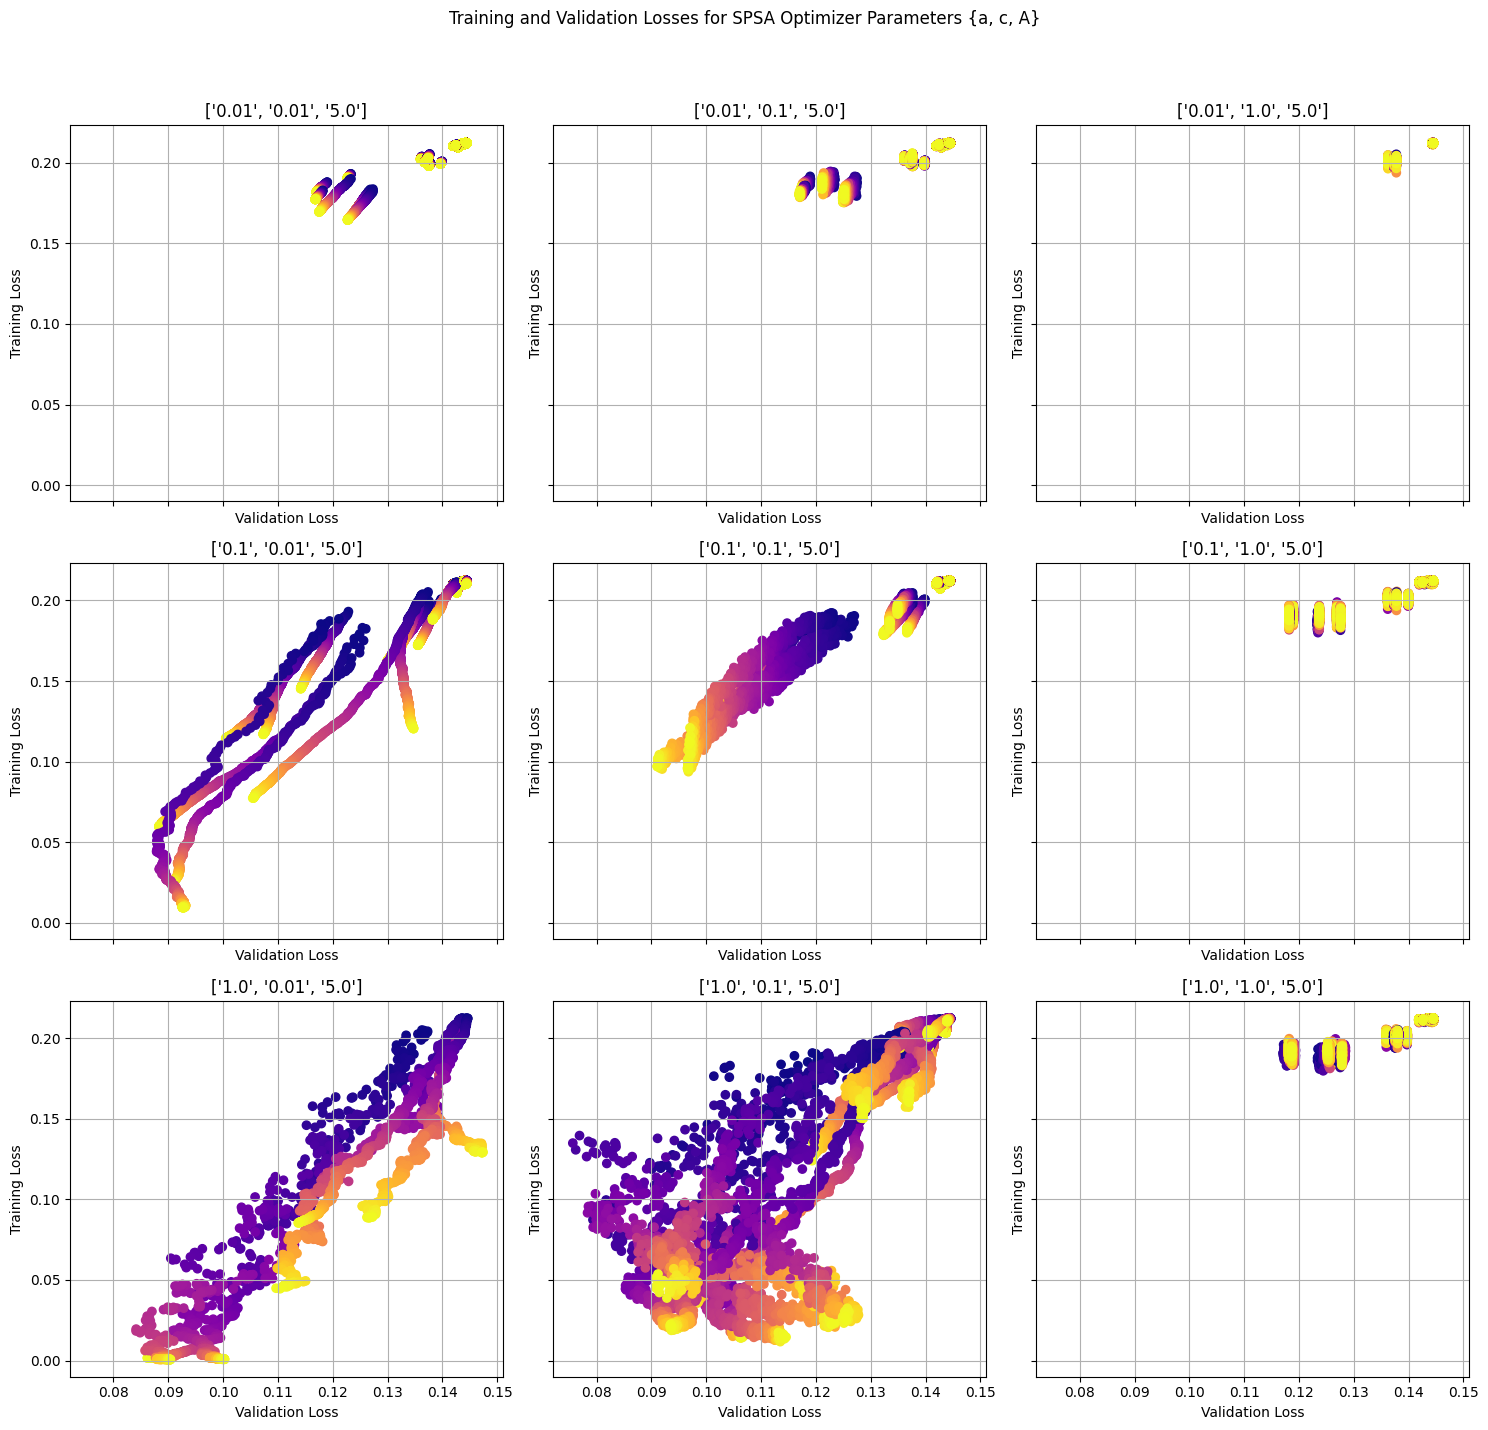

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_models_info contains the list of dictionaries with model information
# Filter the models where optimizer_hyperparams_str[0] == '0.01'
filtered_models = [model_info for model_info in all_models_info]# if model_info['optimizer_hyperparams_str'][0] == '0.01']

# Get unique optimizer parameter configurations and their respective counts
optimizer_params_values, counts = np.unique([tuple(model_info['optimizer_hyperparams_str']) for model_info in filtered_models], axis=0, return_counts=True)

# Filter unique configurations that have at least two occurrences (repeats)
unique_configs_with_repeats = optimizer_params_values[counts >= 2]

# Determine the number of unique configurations
num_subplots = len(unique_configs_with_repeats)

# Make sure there are at most 9 unique configurations
unique_configs_with_repeats = unique_configs_with_repeats[:9]

# Set up the subplots in a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

# Flatten the axs array for easier plotting
axs = axs.ravel()

# Define the parameter combinations to be plotted in the grid
parameter_combinations = [
    ['0.01', '0.01', '5.0'], ['0.01', '0.1', '5.0'], ['0.01', '1.0', '5.0'],
    ['0.1', '0.01', '5.0'], ['0.1', '0.1', '5.0'], ['0.1', '1.0', '5.0'],
    ['1.0', '0.01', '5.0'], ['1.0', '0.1', '5.0'], ['1.0', '1.0', '5.0']
]

# Plot training and validation losses for each optimizer parameter configuration
for i, params_value in enumerate(parameter_combinations):
    ax = axs[i]
    filtered_models_for_params = [model_info for model_info in filtered_models if model_info['optimizer_hyperparams_str'] == list(params_value)]
    
    for model_info in filtered_models_for_params:
        num_epochs = model_info['num_epochs']
        training_losses = model_info['training_losses']
        validation_losses = model_info['validation_losses']

        epochs = range(1, num_epochs + 1)

        ax.scatter(validation_losses, training_losses, c=epochs, cmap='plasma', label=f"Seed={model_info['seed']}")
        ax.set_xlabel('Validation Loss')
        ax.set_ylabel('Training Loss')
        ax.set_title(f"{params_value}")
        ax.grid(True)

        # Check if the subplot has data to plot before adding the color bar
        if len(ax.collections) > 0:
            pass
            # Add a color bar for this subplot
            #cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
            #cbar = plt.colorbar(ax.collections[0], cax=cax)
            #cbar.set_label('Epoch')

# Remove any empty subplots if there are fewer configurations than the number of subplots
#for i in range(num_subplots, 2):
#    fig.delaxes(axs[i])

plt.suptitle('Training and Validation Losses for SPSA Optimizer Parameters {a, c, A}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Ansatz

In [32]:
all_models_info[90]

{'model_type': 'random',
 'ansatz_name': 'sim14',
 'ansatz_hyperparams_str': ['1', '1', '1'],
 'loss_name': 'mse',
 'optimizer_name': 'spsa',
 'optimizer_hyperparams_str': ['0.1', '0.1', '5.0'],
 'num_epochs': 500,
 'batch_size': 2,
 'seed': 42,
 'model_params': array([0.2778009 , 1.0106646 , 0.72748637, ..., 0.78743473, 0.20092548,
        0.20863984]),
 'training_losses': array([0.18993183, 0.18698127, 0.18227605, ..., 0.09743783, 0.09694972,
        0.09715121]),
 'validation_losses': array([0.12651119, 0.12617395, 0.12557832, ..., 0.09111138, 0.09109115,
        0.09107018])}

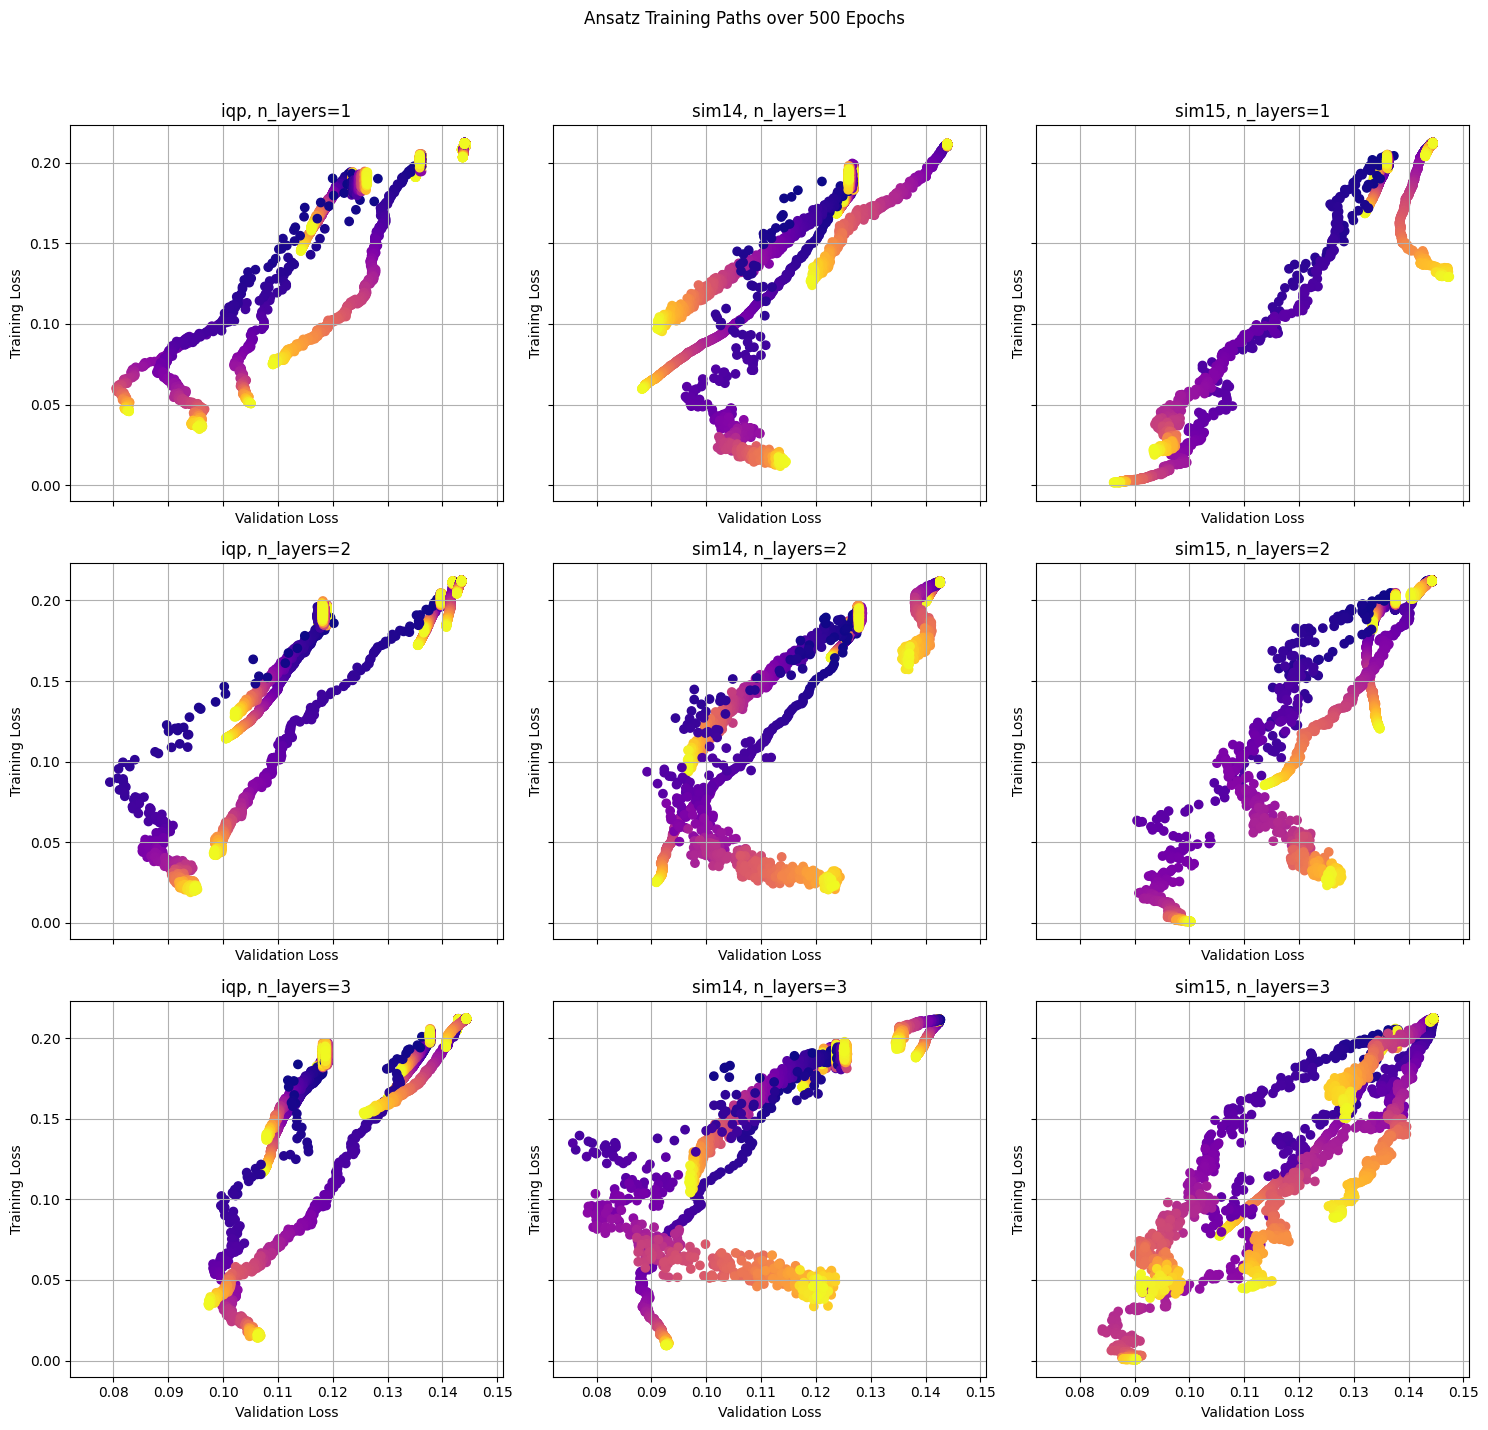

In [33]:
import numpy as np
import matplotlib.pyplot as plt

useful_models = [model for model in all_models_info if model['optimizer_hyperparams_str'] == ['0.1', '0.01', '5.0']]
ansatz_names = ['iqp', 'sim14', 'sim15']
n_layers_values = [1, 2, 3]

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

for row, n_layers in enumerate(n_layers_values):
    for col, ansatz_name in enumerate(ansatz_names):
        ax = axes[row, col]
        
        # ansatz_n_layers_models = [model for model in useful_models if model['ansatz_name'] == ansatz_name and int(model['ansatz_hyperparams_str'][-1]) == n_layers]
        ansatz_n_layers_models = [model for model in all_models_info if model['ansatz_name'] == ansatz_name and int(model['ansatz_hyperparams_str'][-1]) == n_layers]

        for model in ansatz_n_layers_models:
            num_epochs = model['num_epochs']
            training_losses = model['training_losses']
            validation_losses = model['validation_losses']

            epochs = range(1, num_epochs + 1)

            ax.scatter(validation_losses, training_losses, c=epochs, cmap='plasma', label=f"Seed={model['seed']}")
            ax.set_title(f"{ansatz_name}, n_layers={n_layers}")
            ax.set_xlabel("Validation Loss")
            ax.set_ylabel("Training Loss")
            ax.grid(True)
            #ax.legend()

# Adjust layout
plt.suptitle('Ansatz Training Paths over 500 Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()